# Dataset shift

In the previous assignment you have worked with wafer map data from a semiconductor manufacturing process, and developed a calibrated binary classifier for identifying whether a finished wafer contains a known pattern of faulty chips.

Imagine the company has evaluated several classifiers and deployed one of them in production, as part of a larger system for identifying the root causes of faulty chips. The root cause analysis relies on the expertise of human operators. When the root cause of faulty chips on a wafer can be identified, the process parameters can be adjusted, reducing the number of faulty chips and increasing wafer yield.

Ideally, the company would like all wafers to be analyzed by the operators, however, their capacity is limited. Therefore, the classifier is used as part of a filtering stage to select wafers which are suitable for further analysis by the operators, based on whether the wafers contain a known pattern of faulty chips.

After a month, the company observes degrading wafer yield. They suspect it is due to a drop in classification performance of the classifier: missing wafers that are suitable for further analysis will prevent the operators from identifying the root causes of faulty chips and adapting the process parameters, resulting in more faults and lower yield. Your task is to investigate this suspicion.

#### Overview

You are given two datasets: a labeled *training* set that represents the data used to train the classifier and a partially labeled *production* set representing the data collected after the model was deployed in production. Both datasets are based on the WM-811K dataset containing annotated wafer maps collected from real-world fabrication (see `./data/readme.txt`).

You are also given the implementation of the deployed classifier.

The assignment consists of two parts:

- Part 1 is about defining the data mining objective.
- Part 2 is about addressing the data mining objective.

#### Deliverables

There are two deliverables for this assignment:

- Report: it should be max 4 pages long (double column). It's structure should follow the CRISP-DM process. A template is provided in the assignment on Canvas. The report will be graded.
- This notebook: it must contain all the supporting material for the report, i.e. all the results and figures must be generated in this notebook. This notebook will not be graded, however, missing supporting material for the report will affect the grade of the report.

Deliver a `.zip` archive with three files:

- `dataset_shift_<groupid>.pdf` file containing the report,
- `dataset_shift_<groupid>.ipynb` file containing this filled in **and executed** notebook,
- `dataset_shift_<groupid>.html` file containing this filled in **and executed** notebook rendered to html,

by submitting it to the corresponding assignment on Canvas. `<groupid>` refers to your group number on Canvas. You may submit as many times as you like before the deadline. The last submission counts.

Throughout this notebook you will find cells starting `# // BEGIN_TODO`.

- Fill in all your code between these `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]` tags.
- Do not edit these tags in any way, or else your answers may not be processed by the grading system.
- You can add as many code and text cells as you want between the `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]` tags to make your code nicely readable.
- Unlike the previous assignment, your submitted notebook will *not* be evaluated by Momotor. You are free to use any libraries you like, but make sure you import all your libraries between the `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]` tags.

You are encouraged to play with the data and extend this notebook in order to obtain your answers. You may insert cells at any point in the notebook, but remember:
<br/><br/>
<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Only the code in your answer cells (i.e. between `# // BEGIN_TODO` and `# // END_TODO`) will be extracted and evaluated.
</div>

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu.
</div>

Let's get started by filling in your details in the following answer cell. Assign your group number, your names and student ids to variables `group_number`, `name_student1`, `id_student1`, `name_student2`, `id_student2`, e.g.:

```
# // BEGIN_TODO [AUTHOR]
group_number = "7"
name_student1 = "John Smith"
id_student1 = "1234567"
name_student2 = "Jane Miller"
id_student2 = "7654321"
# // END_TODO [AUTHOR]
```

In [1]:
#// BEGIN_TODO [AUTHOR]

group_number = "24"
name_student1 = "Ambarish Moharil"
id_student1 = "1704818"
name_student2 = "Saptarshi Chakravarty"
id_student2 = "7654321"

#// END_TODO [AUTHOR]

## Import libraries

You are free to use any libraries you like. However, please import any additional libraries between `# // BEGIN_TODO [CODE]` and `# // END_TODO [CODE]` tags in Part 2.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load the data

The training data, that was used to train the classifier before deployment, resides in the `./data/wafer_training.pkl` pickle file.

In [3]:
with open('./data/wafer_training.pkl', 'rb') as f:
    X_train, y_train = pickle.load(f)

`X_train` contains the wafer maps and `y_train` contains the labels. The maps are 26x26 pixels, a pixel of value 0 represents the background, a pixel of value 1 indicates a good chip, and a pixel of value 2 indicates a bad chip. An example of a wafer map is shown below.

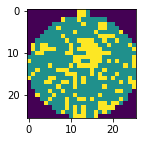

In [4]:
fig, axes = plt.subplots(1, figsize = (2,2))
plt.imshow(X_train[0]);

The production data, that was collected after the classifier was deployed in production, resides in the `./data/wafer_production.pkl` pickle file.

In [5]:
with open('./data/wafer_production.pkl', 'rb') as f:
    X_production, y_production = pickle.load(f)

`X_production` contains the wafer maps and `y_production` contains the labels. The samples are listed in the same order as they were collected.

The wafer maps were labeled by human experts according to whether the wafer map contains a known bad chip pattern or not:

- 1: a pattern (one of the 8 patterns in the Calibration assignment)
- 0: no pattern
- -1: unlabeled sample

You will observe that `y_production` is only partially labeled, i.e. some samples are unlabeled. You can imagine that labeling is time consuming and expensive process and only a subset was labeled, e.g. for monitoring the performance of the classifier.

An example of the wafer map with and without known pattern is shown below.

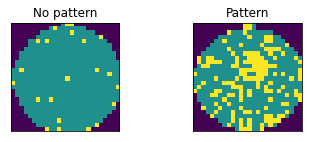

In [6]:
unique_classes, class_indexes = np.unique(y_train,return_index=True)
class_names = ["No pattern", "Pattern"]
fig, axes = plt.subplots(1,2, figsize = (6,2))
for num_index, index in enumerate(class_indexes):
    axes[num_index].imshow(X_train[index])
    axes[num_index].set_title(class_names[unique_classes[num_index]])
    axes[num_index].set_xticks([])
    axes[num_index].set_yticks([])

## Define the classifier

Here is the implementation of the deployed classifier. It is a multi-layer perceptron with one hidden layer containing 10 neurons, that is trained using the Adam optimizer with early stopping. It expects a vector as input.

In [7]:
from sklearn.neural_network import MLPClassifier

deployed_classifier = MLPClassifier(hidden_layer_sizes=(10), early_stopping=True, tol=1e-4, validation_fraction=0.1,
                                n_iter_no_change=20, solver="adam", max_iter=100, random_state=1)

## Part 1: identify the data mining objective

Think of a data mining objective that can be derived from the description above. The objective should be general enough to prevent similar problems from occurring in the future. We will discuss your objectives during the lab session on October 6th and decide on a common objective to be addressed by all groups (it will be posted on Teams for those unable to attend the lab session). Feel free to explore the data.

In [8]:
# TODO: Explore the data

#PLAN OF ACTION : 

#okay so we need to detect when the dataset shift is happening.
#our plan:- 
#we will construct a VAE, which we will train on the input distribution of our data and measure the recons and 
# KL Divergence loss. Further more, to obtain the best reconstruction our obj would be to max the PR-AUC.
#Once we have done this, we will look at the production dataset and look for the drop in the PR AUC metric.
#For those samples, we will get the MLP clf predictions and investigate if the clf is giving a poor perf.
#If that is indeed the case, then we can say for sure that the samples are OOD.


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.4, random_state = 42)

In [10]:
#Create the dataset class
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from torch import nn


class CreateDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, requires_grad= True, dtype = torch.float32)
        self.targets = torch.tensor(targets, dtype = torch.float32)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        
        return len(self.data) 


In [117]:
#create the training dataloader
train_dataset = CreateDataset(X_train,y_train)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=10)

#create the validation dataloader
val_dataset = CreateDataset(X_val,y_val)
val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=10)

#for production dataset
prod_dataset = CreateDataset(X_production,y_production)
prod_dataloader =  torch.utils.data.DataLoader(prod_dataset, batch_size=10)

In [98]:
import numpy as np
import pickle
import requests
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc


#Create a Variational Autoencoder

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.input_layer = nn.Linear(input_dim, hidden_dim) 
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.sigma_layer = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, batch_input):
        
        
        h = nn.ReLU()(self.input_layer(batch_input)) #[N X H], H = hidden_dim, N = batch_size
        h = nn.ReLU()(self.hidden_layer(h)) #[N X H]
        
        mu = self.mu_layer(h)
        log_sigma = self.sigma_layer(h)
        
        z = self.reparam(mu, log_sigma)
        
        return z, mu, log_sigma
    
    def reparam(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        
        z = mu + sigma*eps
        
        return z
    
#The encoder has now encoded the the input into an L dim latent vector Z, we need to decode z in order to sample from p(x)
#Thus we define a decoder 

class Decoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, output_dim):
        super(Decoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        self.hidden_layer1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        
        h_o = nn.ReLU()(self.hidden_layer1(z))
        h_o = nn.ReLU()(self.hidden_layer2(h_o))
        
        reconstruction = nn.Sigmoid()(self.out(h_o))
        
        return reconstruction
        
#Now we can define the VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_input):
        
        z, mu, log_sigma = self.encoder(batch_input)
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_sigma, z
    
#We need to define the KL-Divergence loss and the reconstruction loss

def loss_function(x, x_reconstr, mu, log_sigma,reduce=True):
    if reduce:
        reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
        kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
        total_loss = reconstr_loss + kl_loss
    else:
        reconstr_loss =torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=(1))
        kl_loss =  0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
        total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

In [115]:
#Instantiate the classes
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
x_dim = 26*26
latent_dim = 5
hidden_dim = 500
batch_size = 10
lr = 6e-04
epochs = 500

encoder = Encoder(input_dim = x_dim, hidden_dim = hidden_dim, latent_dim = latent_dim).cuda()
decoder = Decoder(hidden_dim = hidden_dim, latent_dim = latent_dim, output_dim = x_dim).cuda()

vae = VAE(encoder = encoder, decoder = decoder).cuda()

In [116]:
#Train the VAE - objective : min KL Loss, max PR-AUC score

def compute_val_metric(model, val_loader):
    losses, targets = [], []
    with torch.no_grad():
        model.eval()
        for batch_idx, val_data in enumerate(val_loader):
            x, y = val_data
            if x.size()[0] == 10:
                x = x.view(batch_size, x_dim)
                x = x.to(DEVICE)
                outputs, mu, log_sigma,z = model.forward(x)
                loss, reconstruction_loss, kl_loss = loss_function(x, outputs,mu, log_sigma, reduce = False)
                losses.append(loss)
                targets.append(y)
                
    scores = torch.stack(losses, axis=0).view(-1)
    targs = torch.stack(targets, axis=0).view(-1)
    #scale the scores - min-max scaling (for the predicted probabilities)
    scores = (scores - scores.min())/(scores.max() - scores.min())
    scores = scores.cpu().detach().numpy()
    fpr, tpr, roc_thresholds = roc_curve(targs, scores)
    precision, recall, pr_thresholds = precision_recall_curve(targs, scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    
    return fpr,tpr,precision,recall,roc_auc,pr_auc

optimizer = Adam(vae.parameters(), lr=lr)
print("Start training VAE...")

vae.train()

for epoch in range(epochs):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, data in enumerate(train_dataloader):
        x, y = data
        if x.size()[0] == 10:
            x = x.view(batch_size, x_dim)
            x = x.to(DEVICE)
            optimizer.zero_grad()
            x_reconstr, mu, log_sigma, z = vae(x)
            loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)

            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()

            loss.backward()
            optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    fpr,tpr,precision,recall,roc_auc,pr_auc = compute_val_metric(vae,val_dataloader)


    
    
    
    print("\tEpoch", epoch + 1, "\nAverage Loss: ", overall_loss / n_datapoints)
    print("\nReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints, 
         "  \tVal PR_AUC", pr_auc)
    print('\n')
    
print("Training complete!")




Start training VAE...
	Epoch 1 
Average Loss:  123.29097383341212

Reconstruction Loss: 121.66423709164759 	KL Loss: 1.6267365078637555   	Val PR_AUC 0.8747671807608358


	Epoch 2 
Average Loss:  110.16977220280155

Reconstruction Loss: 109.0480713668143 	KL Loss: 1.1217009740650274   	Val PR_AUC 0.8749048254224979


	Epoch 3 
Average Loss:  107.26479958698249

Reconstruction Loss: 105.56316796563993 	KL Loss: 1.7016312751041096   	Val PR_AUC 0.8731336260872833


	Epoch 4 
Average Loss:  106.66970510300557

Reconstruction Loss: 104.9726029122711 	KL Loss: 1.6971021567180657   	Val PR_AUC 0.8736375188298988


	Epoch 5 
Average Loss:  106.0955512368755

Reconstruction Loss: 104.39394119165506 	KL Loss: 1.7016103477235054   	Val PR_AUC 0.8751509190757221


	Epoch 6 
Average Loss:  105.66225928045382

Reconstruction Loss: 103.78825011040755 	KL Loss: 1.8740091257034592   	Val PR_AUC 0.882546115526598


	Epoch 7 
Average Loss:  104.77231698005822

Reconstruction Loss: 102.45380260686206 	KL

	Epoch 57 
Average Loss:  98.53706649488704

Reconstruction Loss: 95.26096700680483 	KL Loss: 3.276099686106299   	Val PR_AUC 0.880404241651272


	Epoch 58 
Average Loss:  98.5761230079991

Reconstruction Loss: 95.24224274264779 	KL Loss: 3.3338804876728423   	Val PR_AUC 0.8809397749103456


	Epoch 59 
Average Loss:  98.57901074840764

Reconstruction Loss: 95.28703994265028 	KL Loss: 3.291971014715304   	Val PR_AUC 0.8793278870073888


	Epoch 60 
Average Loss:  98.40410992081758

Reconstruction Loss: 95.13874294013733 	KL Loss: 3.265367102167409   	Val PR_AUC 0.8810495305286722


	Epoch 61 
Average Loss:  98.46058244644456

Reconstruction Loss: 95.19078419679289 	KL Loss: 3.269798454964996   	Val PR_AUC 0.8801417565448248


	Epoch 62 
Average Loss:  98.56428794131917

Reconstruction Loss: 95.30445716031798 	KL Loss: 3.2598311223801533   	Val PR_AUC 0.8790815241085758


	Epoch 63 
Average Loss:  98.44187668721388

Reconstruction Loss: 95.18533542900329 	KL Loss: 3.256541103921878   	Val

	Epoch 113 
Average Loss:  98.21462452882415

Reconstruction Loss: 94.75626189602409 	KL Loss: 3.4583625404698073   	Val PR_AUC 0.8782735576740069


	Epoch 114 
Average Loss:  97.93024299767367

Reconstruction Loss: 94.7864520224796 	KL Loss: 3.1437909654750946   	Val PR_AUC 0.8807312063924307


	Epoch 115 
Average Loss:  98.01344717232286

Reconstruction Loss: 94.71088482316132 	KL Loss: 3.302562567838438   	Val PR_AUC 0.8809973254204726


	Epoch 116 
Average Loss:  98.10562137676652

Reconstruction Loss: 94.77746609244377 	KL Loss: 3.328155251521214   	Val PR_AUC 0.8778687823698146


	Epoch 117 
Average Loss:  98.06044128806728

Reconstruction Loss: 94.73834403457155 	KL Loss: 3.3220970761244466   	Val PR_AUC 0.8795078247379988


	Epoch 118 
Average Loss:  97.90018613778861

Reconstruction Loss: 94.72201981271148 	KL Loss: 3.1781663019945667   	Val PR_AUC 0.879013408682881


	Epoch 119 
Average Loss:  98.24839450325935

Reconstruction Loss: 94.90704162986415 	KL Loss: 3.3413532026254

	Epoch 169 
Average Loss:  97.67210891626443

Reconstruction Loss: 94.43575711584396 	KL Loss: 3.236352033675856   	Val PR_AUC 0.8738559198827788


	Epoch 170 
Average Loss:  97.90586042464918

Reconstruction Loss: 94.69598991248259 	KL Loss: 3.2098708426117137   	Val PR_AUC 0.877276425437394


	Epoch 171 
Average Loss:  97.7774260113953

Reconstruction Loss: 94.45857540057723 	KL Loss: 3.3188505306365386   	Val PR_AUC 0.8788759321842874


	Epoch 172 
Average Loss:  97.8147027082504

Reconstruction Loss: 94.54215476649583 	KL Loss: 3.2725478785812476   	Val PR_AUC 0.8765847305277769


	Epoch 173 
Average Loss:  98.07223841187302

Reconstruction Loss: 94.69870481065884 	KL Loss: 3.373533665602374   	Val PR_AUC 0.8764705512925803


	Epoch 174 
Average Loss:  97.86352294144358

Reconstruction Loss: 94.58031546234325 	KL Loss: 3.283207378265964   	Val PR_AUC 0.8788855758584393


	Epoch 175 
Average Loss:  97.83246471623706

Reconstruction Loss: 94.40193493108082 	KL Loss: 3.430529634512154

	Epoch 225 
Average Loss:  97.70924134467059

Reconstruction Loss: 94.47150466821756 	KL Loss: 3.2377370773606997   	Val PR_AUC 0.8778292176291927


	Epoch 226 
Average Loss:  97.74673473576831

Reconstruction Loss: 94.40019286331857 	KL Loss: 3.346541715731287   	Val PR_AUC 0.8774315913547881


	Epoch 227 
Average Loss:  97.79750039653413

Reconstruction Loss: 94.42661991969796 	KL Loss: 3.3708807854136085   	Val PR_AUC 0.8769273844594362


	Epoch 228 
Average Loss:  97.71998151062401

Reconstruction Loss: 94.35960961603055 	KL Loss: 3.3603719638411405   	Val PR_AUC 0.8765541710598963


	Epoch 229 
Average Loss:  97.71046068713923

Reconstruction Loss: 94.49816396919785 	KL Loss: 3.212296536925492   	Val PR_AUC 0.8771033326886006


	Epoch 230 
Average Loss:  97.7491600473975

Reconstruction Loss: 94.43694924518562 	KL Loss: 3.3122106588570177   	Val PR_AUC 0.8782441294410539


	Epoch 231 
Average Loss:  97.65988684004279

Reconstruction Loss: 94.55752073640276 	KL Loss: 3.102366063549

	Epoch 281 
Average Loss:  97.31526889679539

Reconstruction Loss: 94.04444253520602 	KL Loss: 3.270826370093473   	Val PR_AUC 0.8801174561476821


	Epoch 282 
Average Loss:  97.47662991080314

Reconstruction Loss: 94.289423307188 	KL Loss: 3.1872066765074516   	Val PR_AUC 0.8794486369900574


	Epoch 283 
Average Loss:  97.40695369258808

Reconstruction Loss: 94.15656423386496 	KL Loss: 3.2503892728477526   	Val PR_AUC 0.8813163325601795


	Epoch 284 
Average Loss:  97.45074548417595

Reconstruction Loss: 94.17671190006718 	KL Loss: 3.2740335257949345   	Val PR_AUC 0.8809009688709575


	Epoch 285 
Average Loss:  97.45864016781947

Reconstruction Loss: 94.03772590782992 	KL Loss: 3.420913890668541   	Val PR_AUC 0.8791533213311133


	Epoch 286 
Average Loss:  97.35180096474423

Reconstruction Loss: 94.07407063283738 	KL Loss: 3.2777301897668534   	Val PR_AUC 0.8793875114571228


	Epoch 287 
Average Loss:  97.96852001020103

Reconstruction Loss: 94.59238456191531 	KL Loss: 3.3761353438067

	Epoch 337 
Average Loss:  97.28468736782196

Reconstruction Loss: 93.97338474540953 	KL Loss: 3.3113019639519368   	Val PR_AUC 0.8828782651610875


	Epoch 338 
Average Loss:  97.22415511015873

Reconstruction Loss: 94.01553877326333 	KL Loss: 3.208616118218489   	Val PR_AUC 0.8815707296475206


	Epoch 339 
Average Loss:  97.28817441903861

Reconstruction Loss: 93.89406897672423 	KL Loss: 3.3941053354056776   	Val PR_AUC 0.8812926586002774


	Epoch 340 
Average Loss:  97.23773255560808

Reconstruction Loss: 93.92553948080464 	KL Loss: 3.3121930893819043   	Val PR_AUC 0.8816422234096948


	Epoch 341 
Average Loss:  97.19474607819964

Reconstruction Loss: 93.8851083937724 	KL Loss: 3.309637717228786   	Val PR_AUC 0.8810252841289302


	Epoch 342 
Average Loss:  97.38946505989998

Reconstruction Loss: 93.9823251128956 	KL Loss: 3.4071396359972135   	Val PR_AUC 0.8821015693524314


	Epoch 343 
Average Loss:  97.38137883471835

Reconstruction Loss: 93.94544125696656 	KL Loss: 3.4359376457846

	Epoch 393 
Average Loss:  97.18219569503881

Reconstruction Loss: 93.90076332821208 	KL Loss: 3.281432193100073   	Val PR_AUC 0.8820241196988137


	Epoch 394 
Average Loss:  97.19543406492586

Reconstruction Loss: 93.96030829362809 	KL Loss: 3.235125829611614   	Val PR_AUC 0.8843932760475963


	Epoch 395 
Average Loss:  97.2208721962704

Reconstruction Loss: 93.84074318272293 	KL Loss: 3.3801288301018393   	Val PR_AUC 0.8820288627521311


	Epoch 396 
Average Loss:  97.28976343239948

Reconstruction Loss: 93.92904795263983 	KL Loss: 3.3607161540134696   	Val PR_AUC 0.8826850740235731


	Epoch 397 
Average Loss:  97.15110465857633

Reconstruction Loss: 93.8051360112087 	KL Loss: 3.3459687117558374   	Val PR_AUC 0.8806346806958492


	Epoch 398 
Average Loss:  97.29124297123806

Reconstruction Loss: 93.81071065914858 	KL Loss: 3.4805321201397357   	Val PR_AUC 0.8821894235224547


	Epoch 399 
Average Loss:  97.08372872710987

Reconstruction Loss: 93.85158189907196 	KL Loss: 3.2321466652451

	Epoch 449 
Average Loss:  97.0853677348726

Reconstruction Loss: 93.83358406990197 	KL Loss: 3.2517837378629455   	Val PR_AUC 0.8782758451996031


	Epoch 450 
Average Loss:  97.02194839769108

Reconstruction Loss: 93.89048469689241 	KL Loss: 3.131463439601242   	Val PR_AUC 0.8826698006973007


	Epoch 451 
Average Loss:  97.13686270744178

Reconstruction Loss: 93.68226081216412 	KL Loss: 3.4546017567822886   	Val PR_AUC 0.8815435942552099


	Epoch 452 
Average Loss:  97.08581846200737

Reconstruction Loss: 93.77292165573995 	KL Loss: 3.312896700573575   	Val PR_AUC 0.8815134781695377


	Epoch 453 
Average Loss:  97.23785108821407

Reconstruction Loss: 93.90443480667794 	KL Loss: 3.33341636779202   	Val PR_AUC 0.8816321143908259


	Epoch 454 
Average Loss:  97.0230505293342

Reconstruction Loss: 93.7719338192302 	KL Loss: 3.2511167210378464   	Val PR_AUC 0.8816806904626066


	Epoch 455 
Average Loss:  97.24124670332404

Reconstruction Loss: 93.97890811604299 	KL Loss: 3.26233832851337  

In [120]:
# We will have to evaluate our VAE and visualize some reconstructed images
def detect_shift(model, data_loader):
    elbo_list = []
    recon_list = []
    model.eval()
    with torch.no_grad():
        for batch_idx, _data in enumerate(data_loader):
            x, y = _data
            if x.size()[0] == 10:
                x = x.view(batch_size, x_dim)
                x = x.to(DEVICE)
                outputs, mu, log_sigma,z = model.forward(x)
                loss, reconstruction_loss, kl_loss = loss_function(x, outputs,mu, log_sigma, reduce = False)
                elbo_list.append(loss.cpu().numpy())
                recon_list.append(reconstruction_loss.cpu().numpy())
                
    elbo_ = np.concatenate(elbo_list, 0)
    recon_ = np.concatenate(recon_list, 0)
    return elbo_, recon_       

In [124]:
#get values for the validation data

elbo_val, recon_val = detect_shift(vae, val_dataloader)

#get values for the production data

elbo_prod, recon_prod = detect_shift(vae, prod_dataloader )

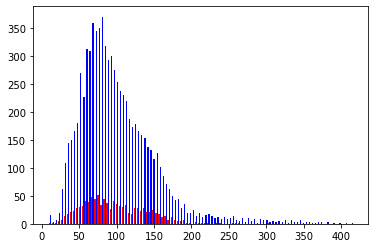

In [136]:
#Visualizing the elbo values
plt.hist([elbo_val, elbo_prod], 100, color=['r', 'b'])
plt.show()

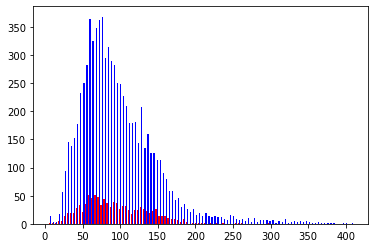

In [137]:
#Visualizing the elbo values
plt.hist([recon_val, recon_prod], 100, color=['r', 'b'])
plt.show()

normal images


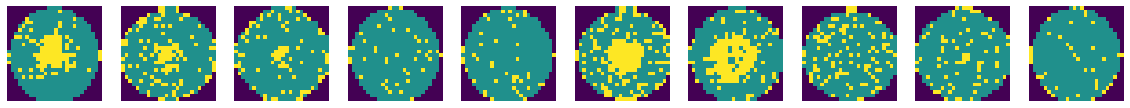

generated images


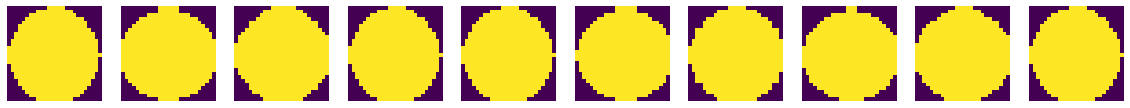

normal images


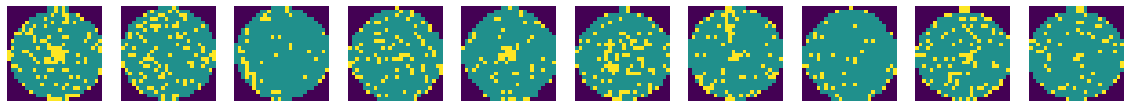

generated images


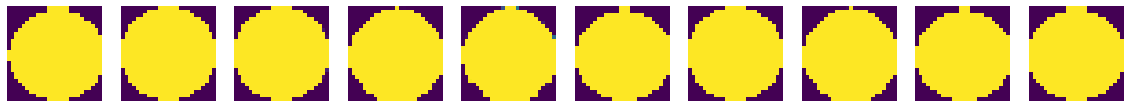

normal images


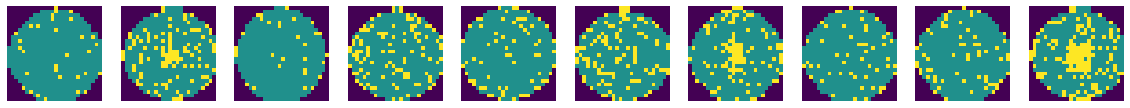

generated images


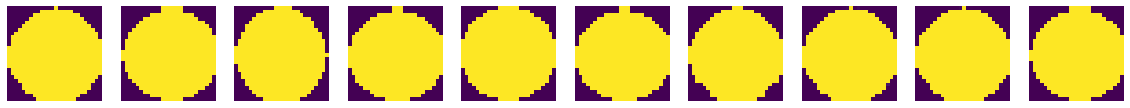

normal images


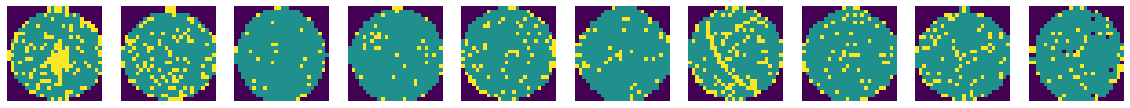

generated images


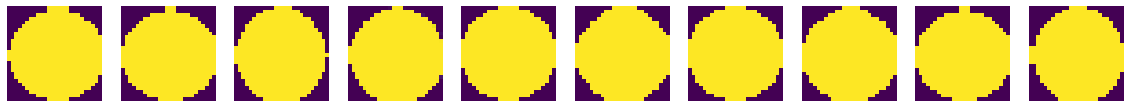

normal images


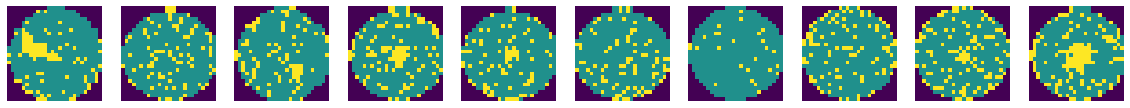

generated images


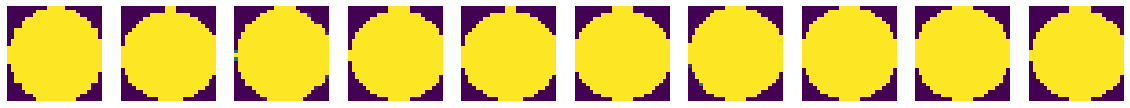

normal images


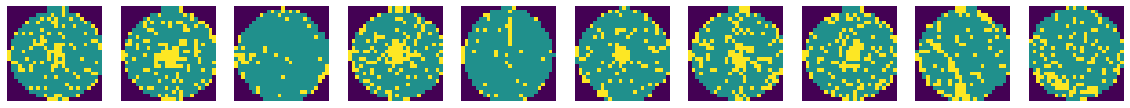

generated images


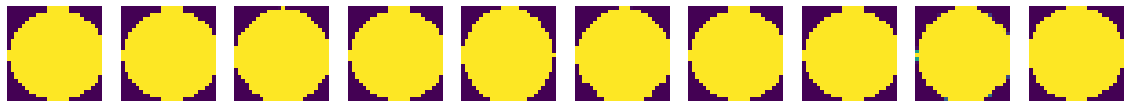

normal images


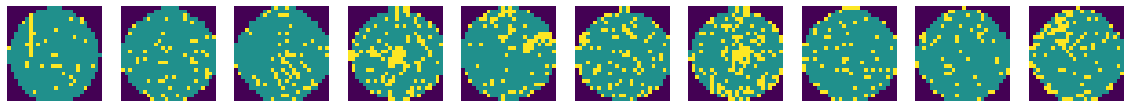

generated images


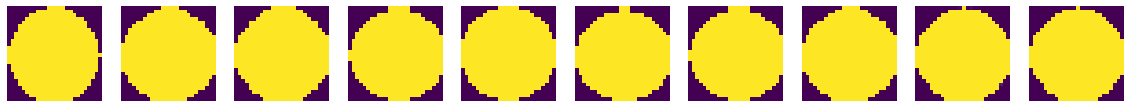

normal images


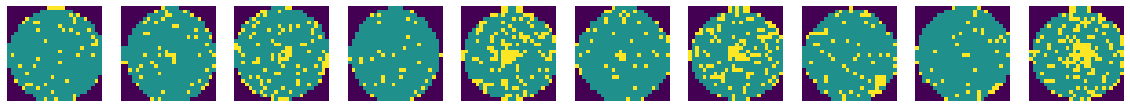

generated images


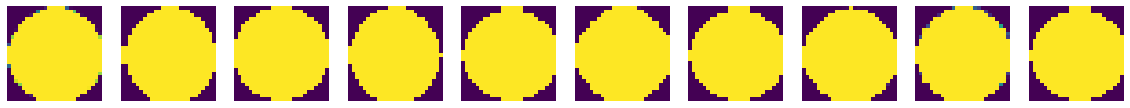

normal images


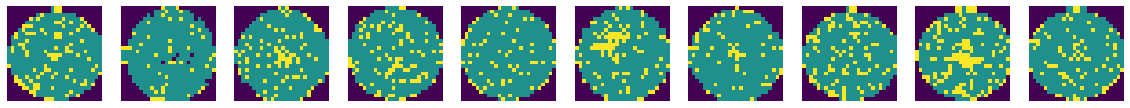

generated images


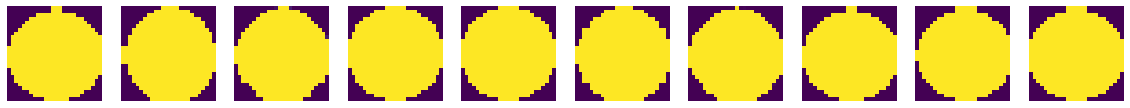

normal images


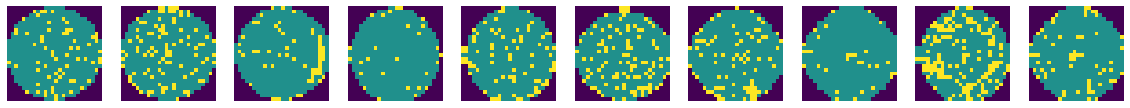

generated images


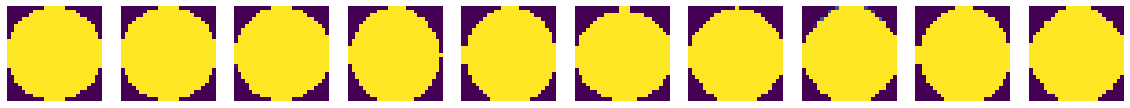

normal images


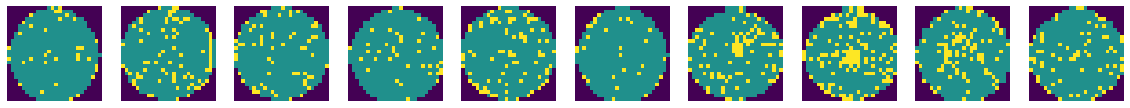

generated images


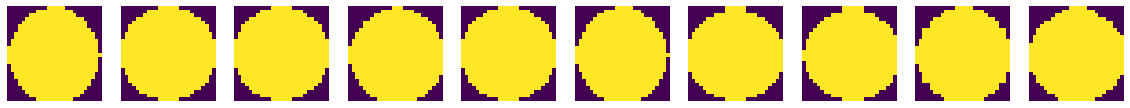

normal images


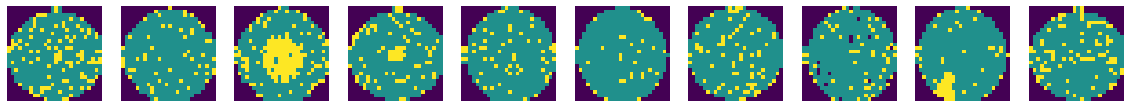

generated images


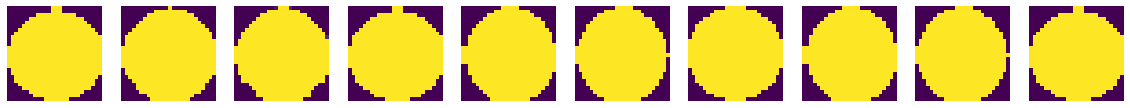

normal images


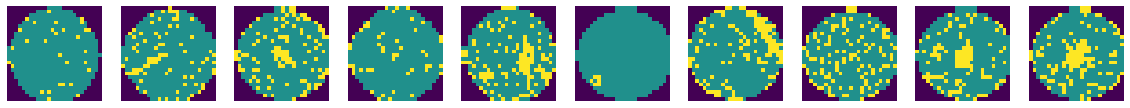

generated images


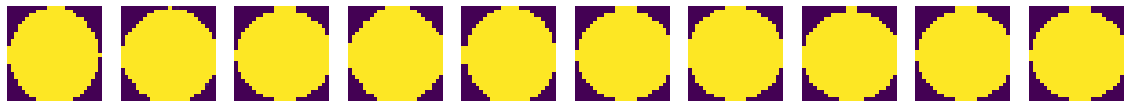

normal images


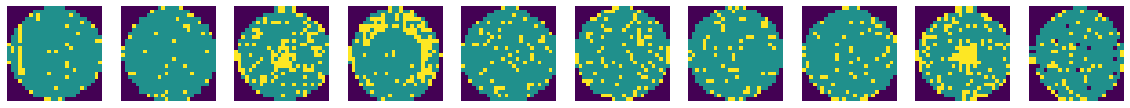

generated images


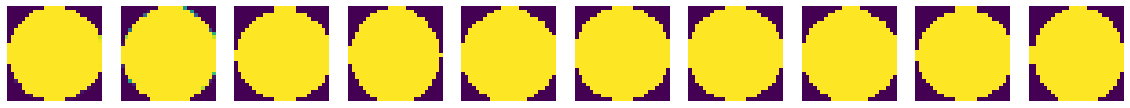

normal images


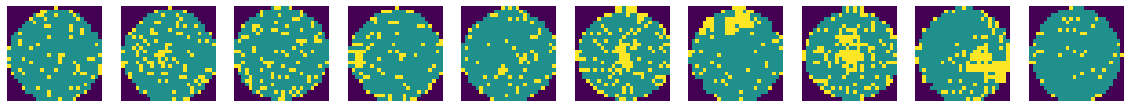

generated images


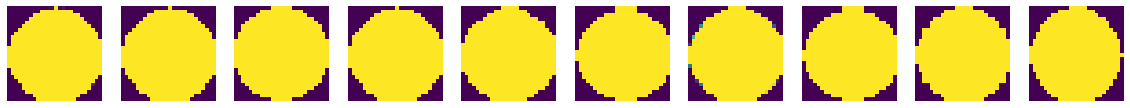

normal images


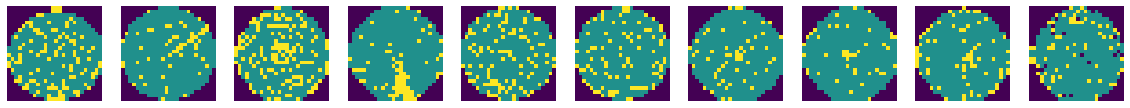

generated images


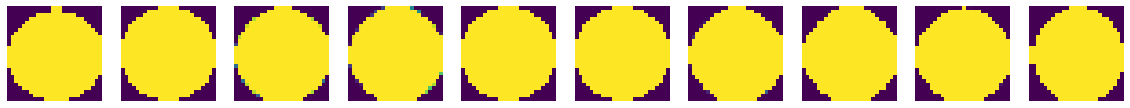

normal images


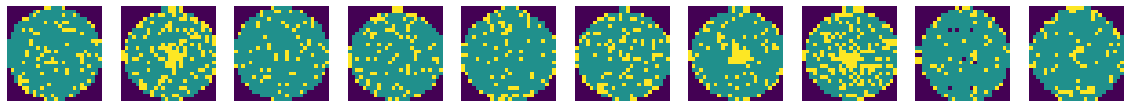

generated images


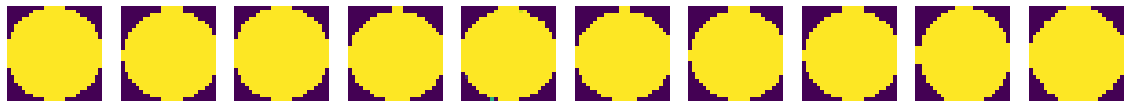

normal images


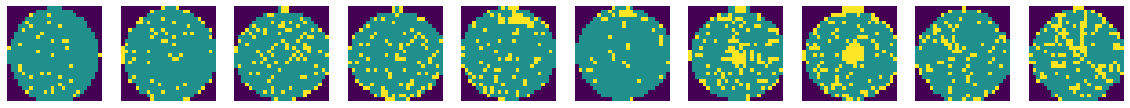

generated images


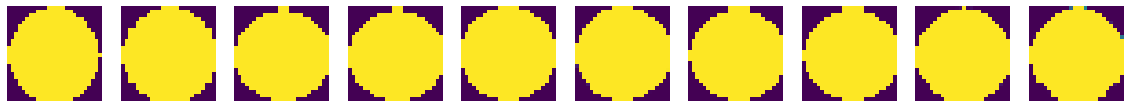

normal images


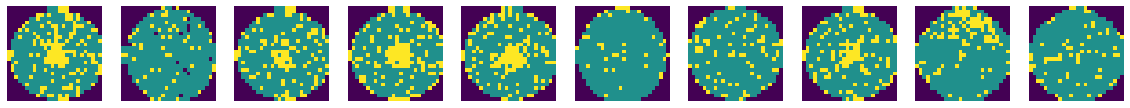

generated images


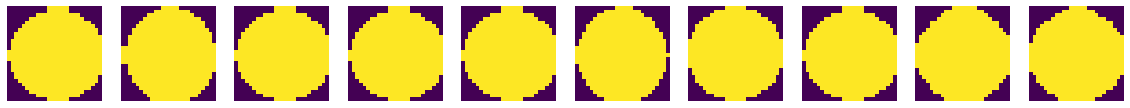

normal images


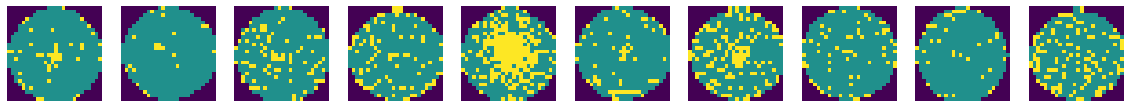

generated images


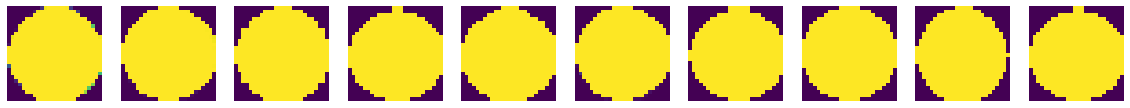

normal images


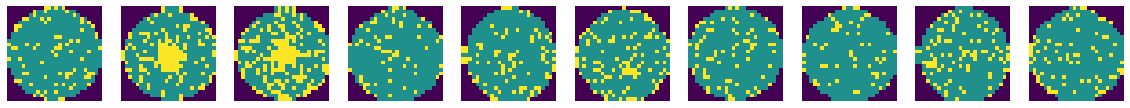

generated images


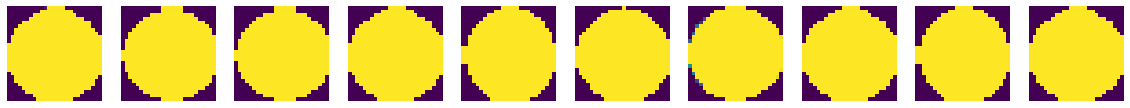

normal images


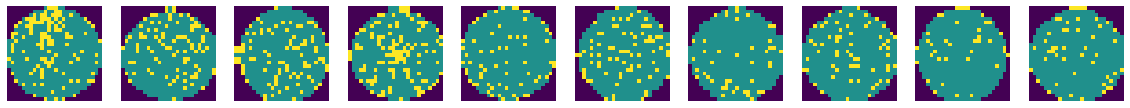

generated images


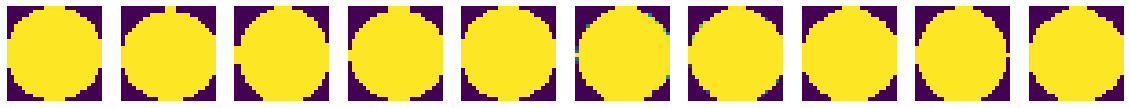

normal images


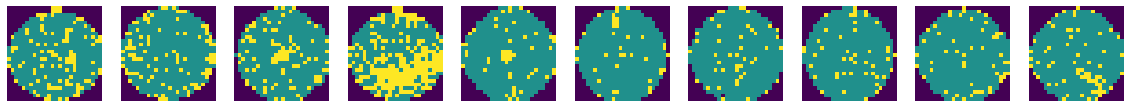

generated images


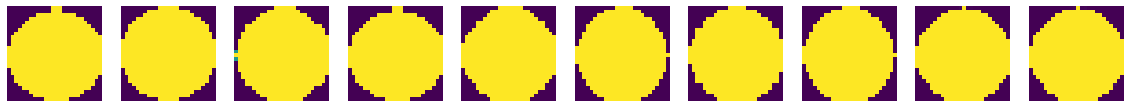

normal images


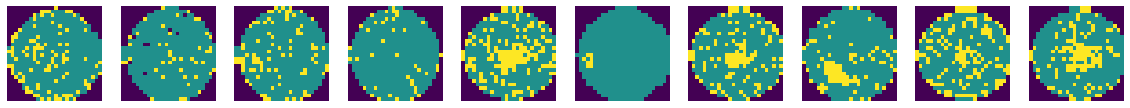

generated images


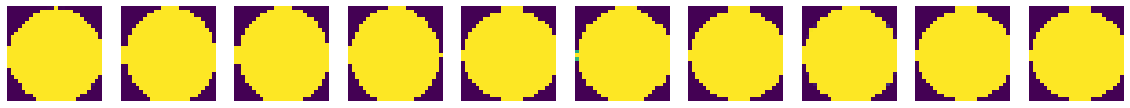

normal images


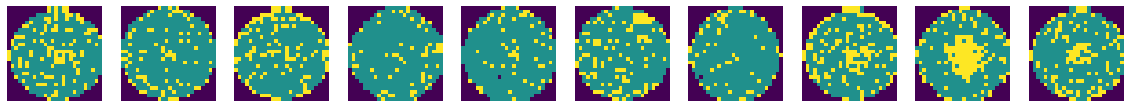

generated images


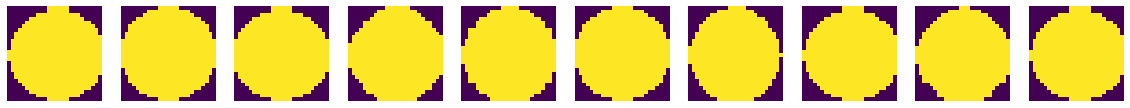

normal images


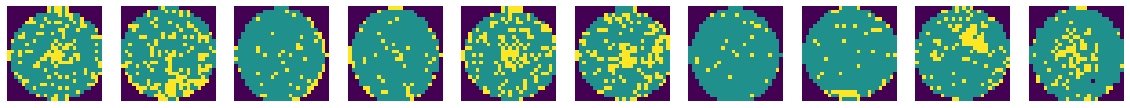

generated images


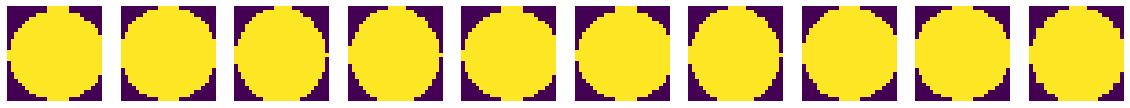

normal images


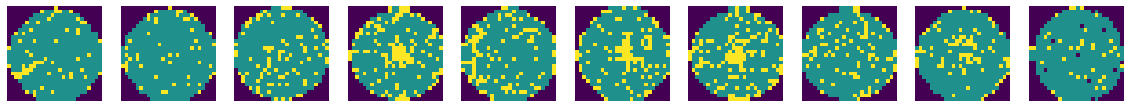

generated images


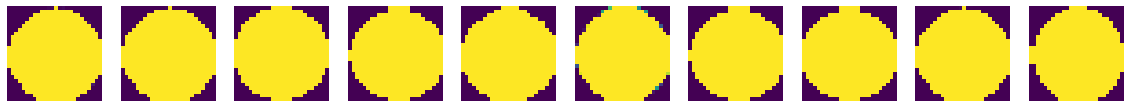

normal images


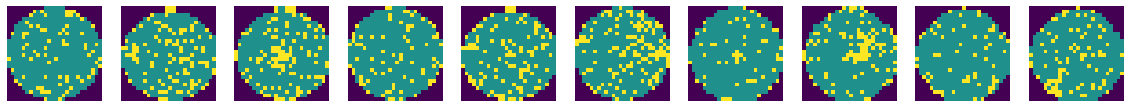

generated images


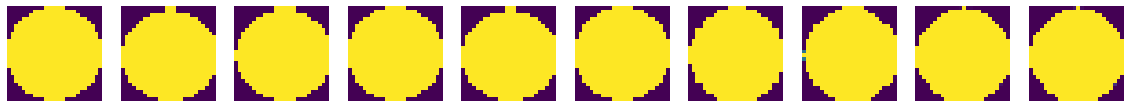

normal images


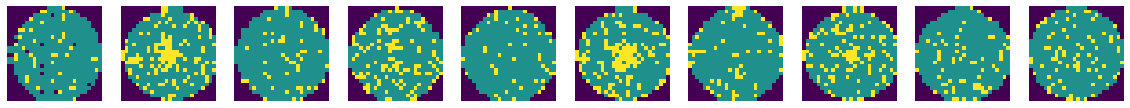

generated images


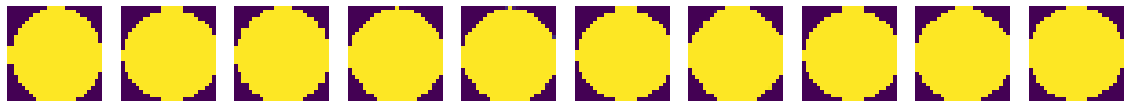

normal images


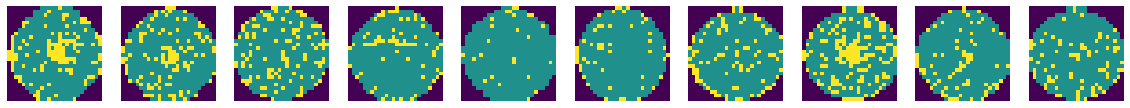

generated images


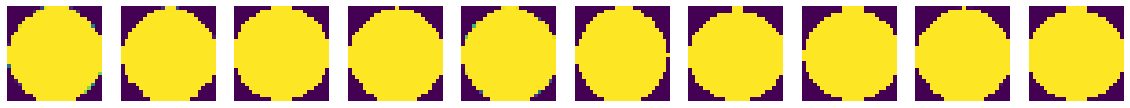

normal images


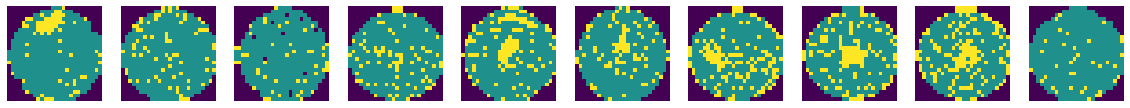

generated images


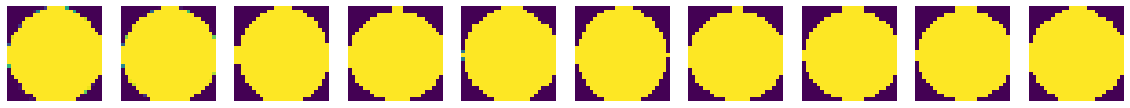

normal images


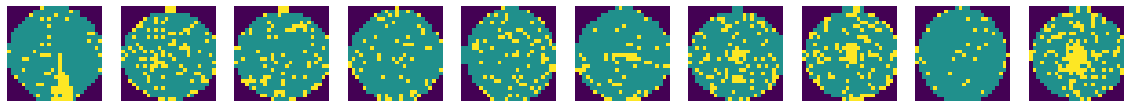

generated images


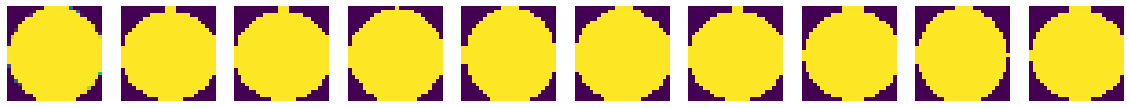

normal images


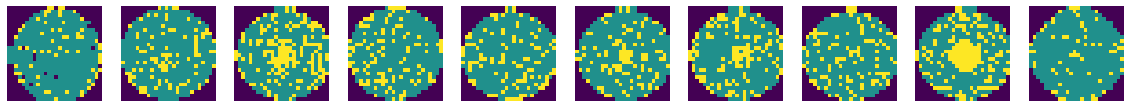

generated images


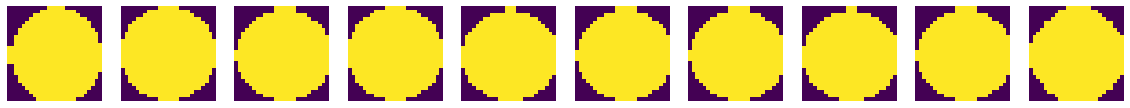

normal images


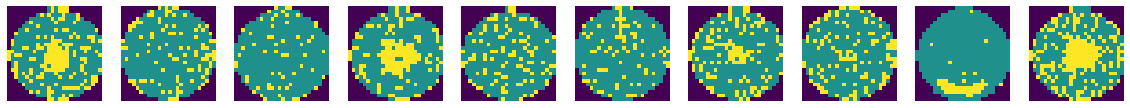

generated images


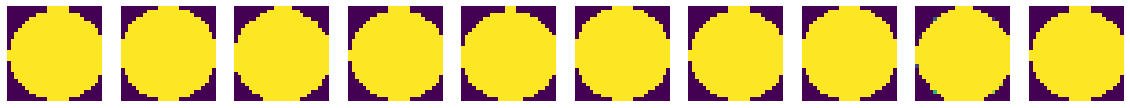

normal images


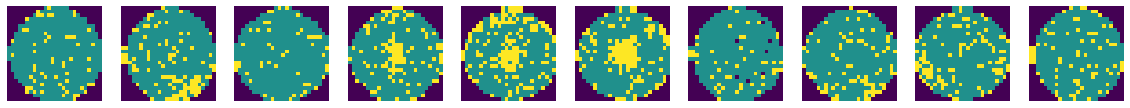

generated images


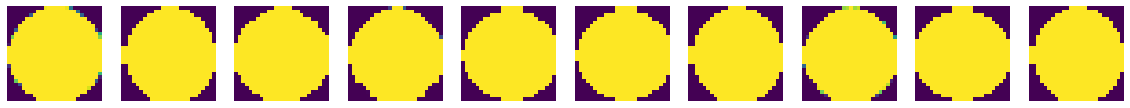

normal images


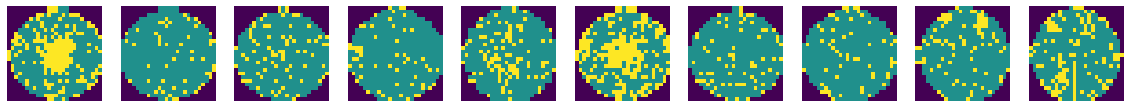

generated images


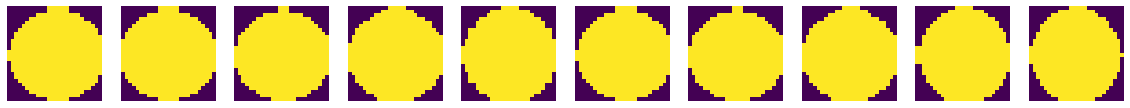

normal images


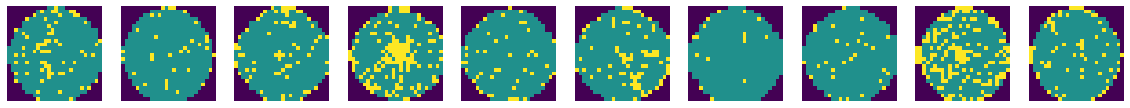

generated images


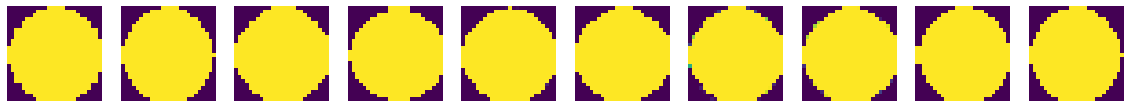

normal images


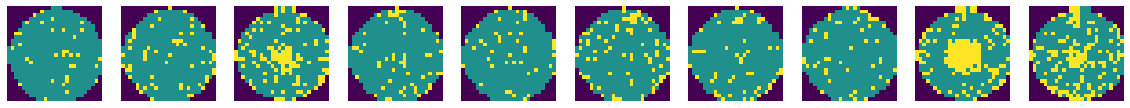

generated images


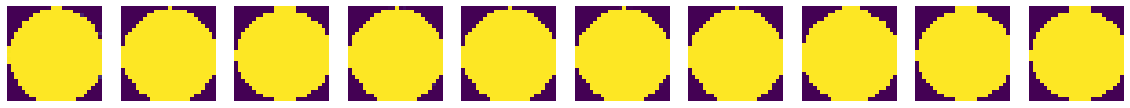

normal images


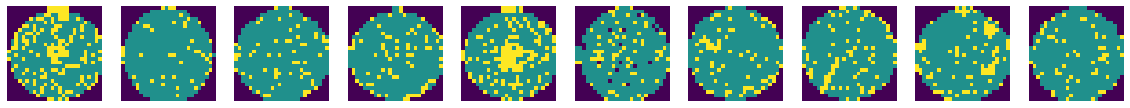

generated images


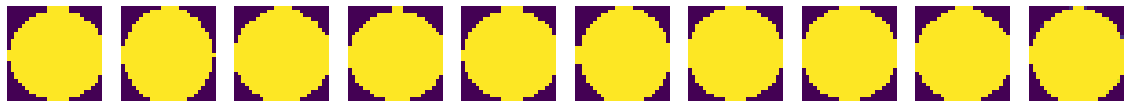

normal images


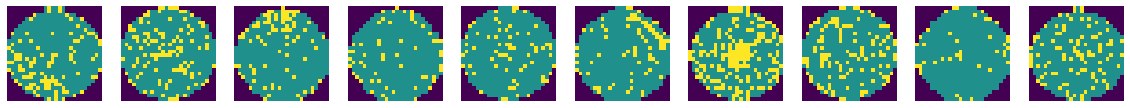

generated images


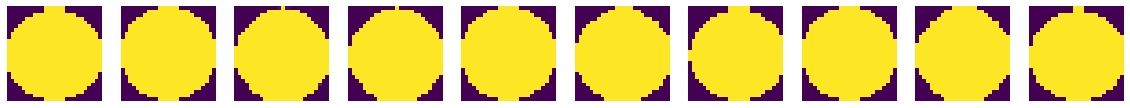

normal images


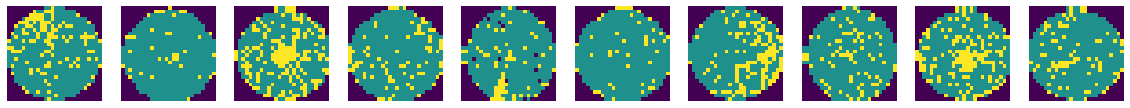

generated images


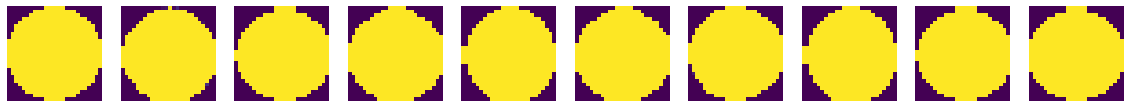

normal images


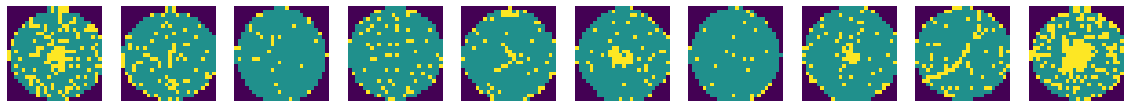

generated images


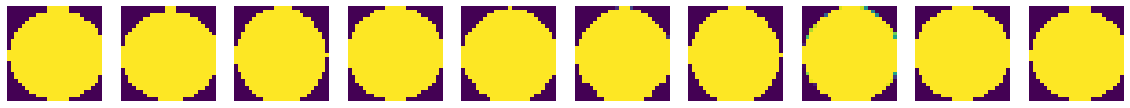

normal images


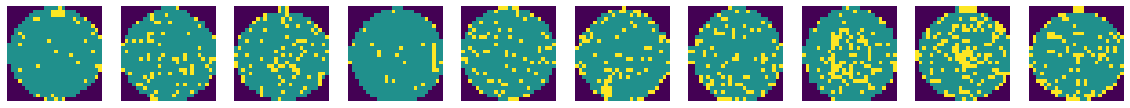

generated images


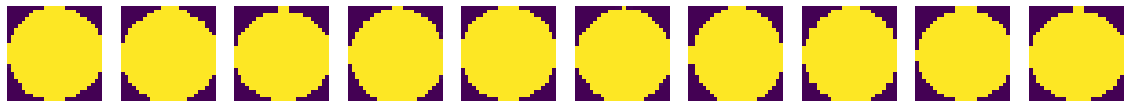

normal images


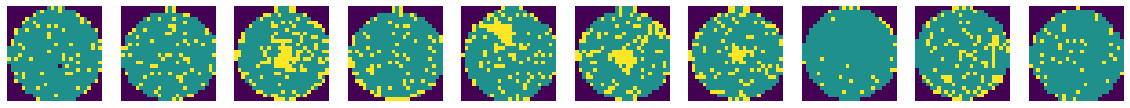

generated images


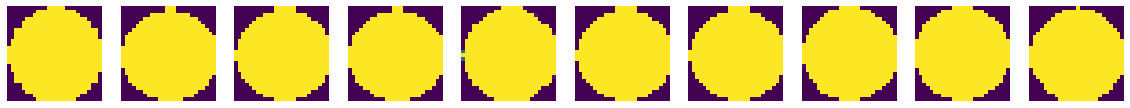

normal images


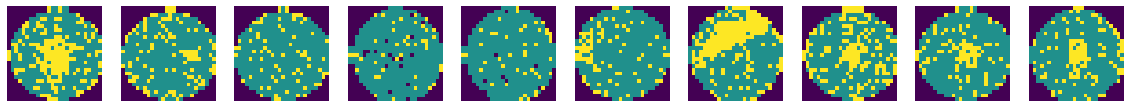

generated images


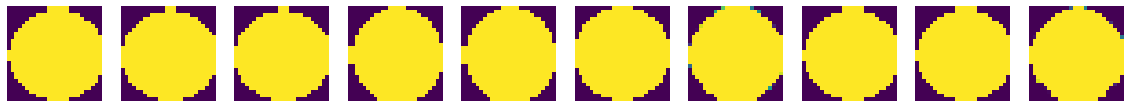

normal images


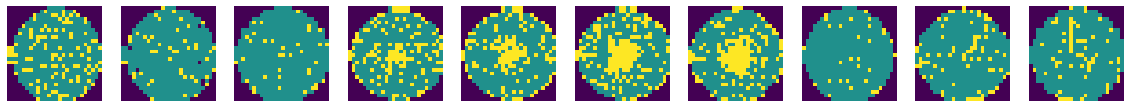

generated images


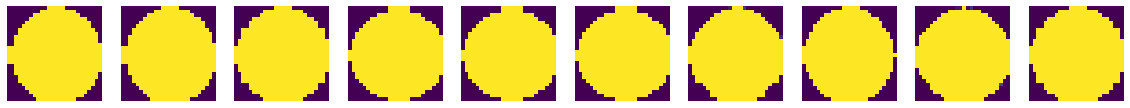

normal images


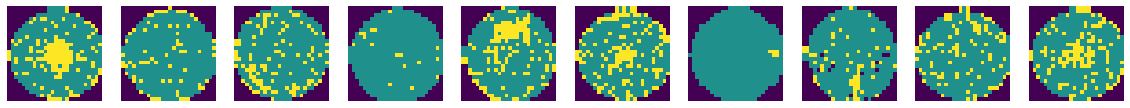

generated images


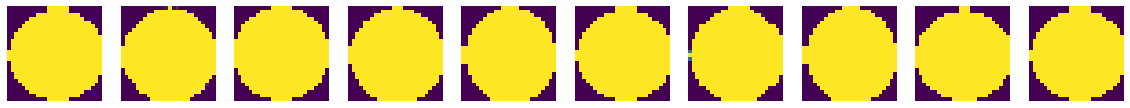

normal images


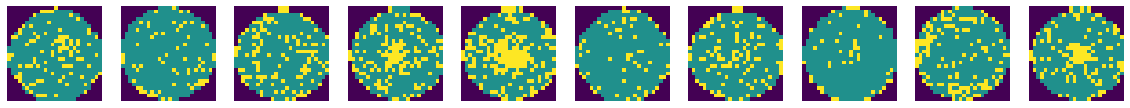

generated images


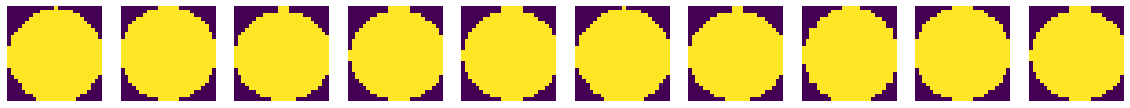

normal images


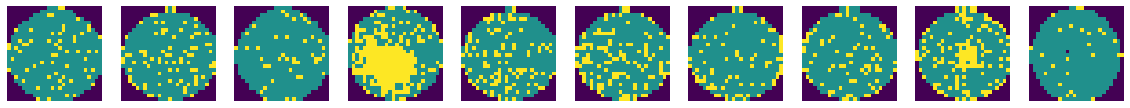

generated images


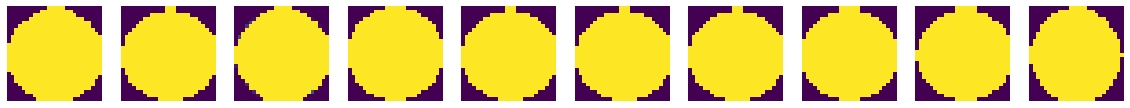

normal images


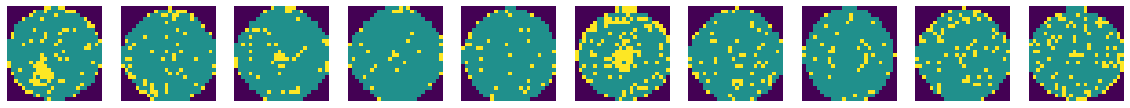

generated images


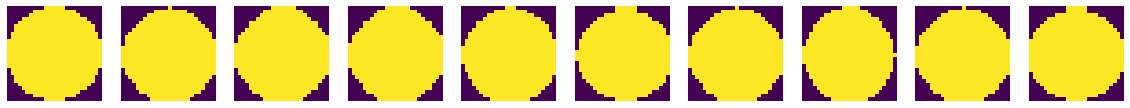

normal images


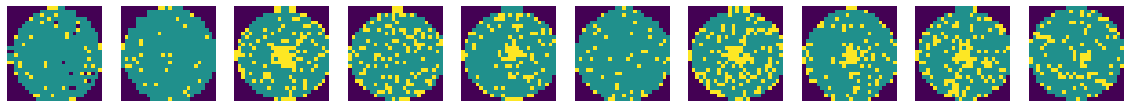

generated images


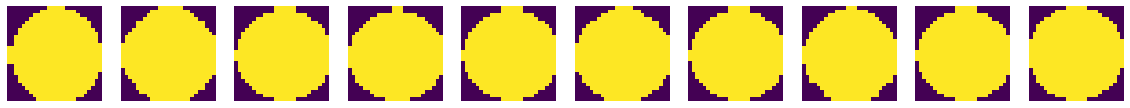

normal images


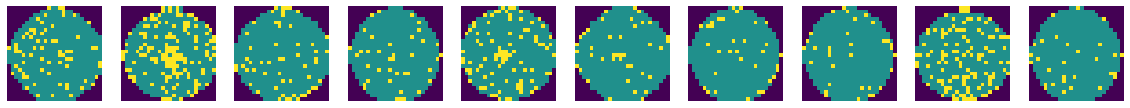

generated images


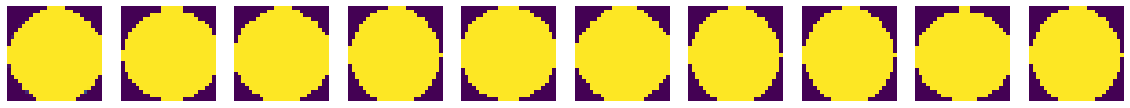

normal images


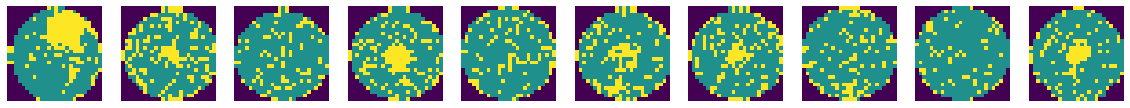

generated images


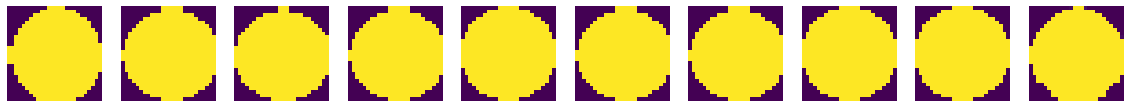

normal images


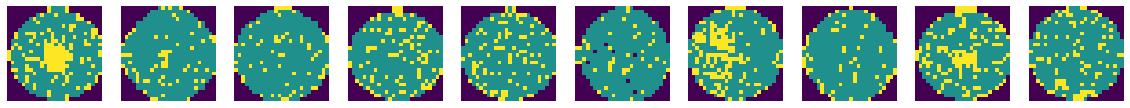

generated images


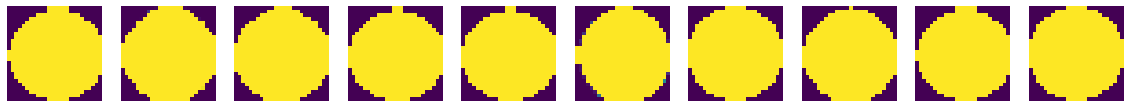

normal images


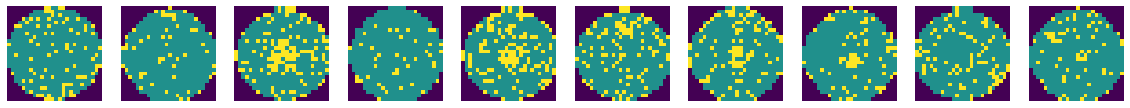

generated images


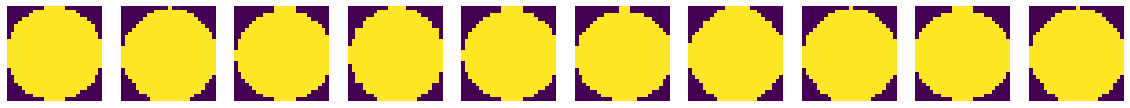

normal images


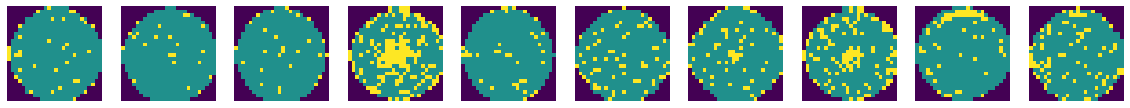

generated images


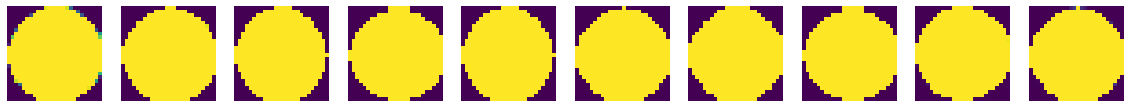

normal images


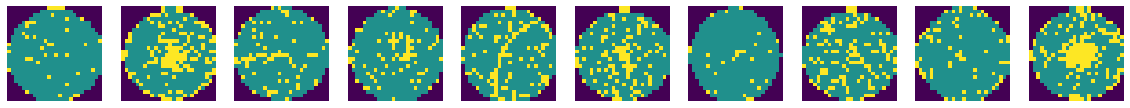

generated images


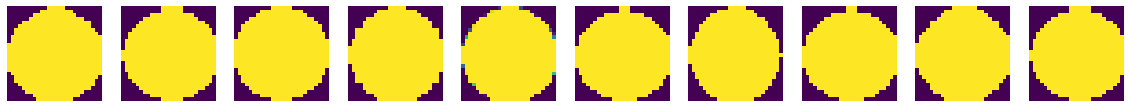

normal images


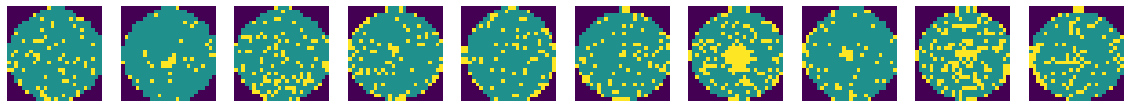

generated images


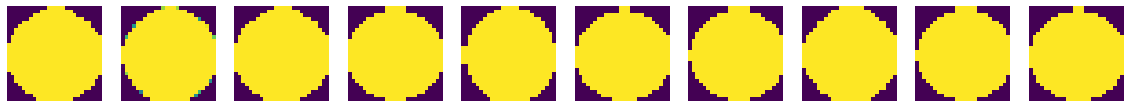

normal images


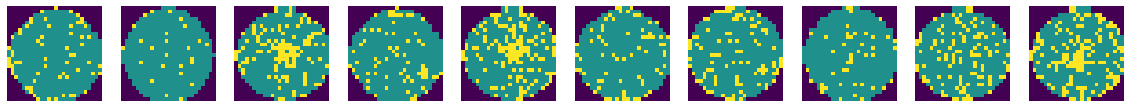

generated images


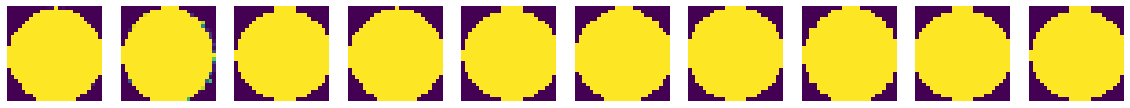

normal images


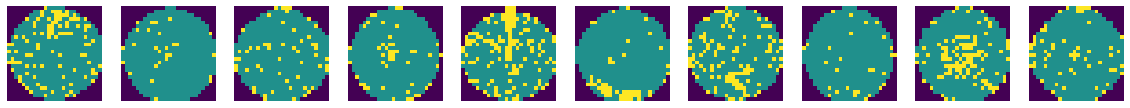

generated images


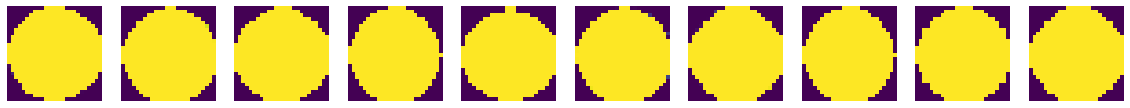

normal images


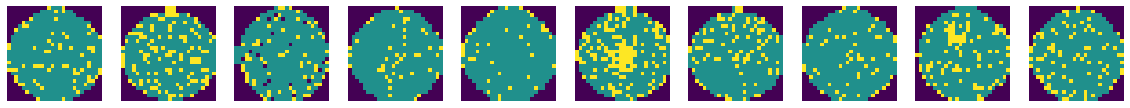

generated images


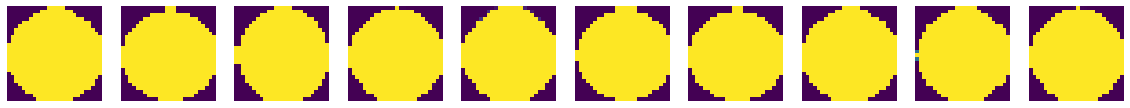

normal images


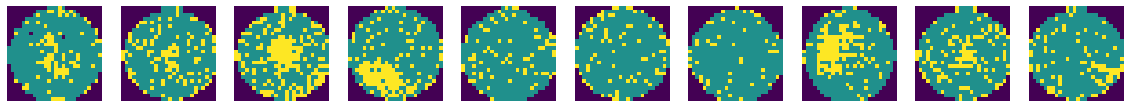

generated images


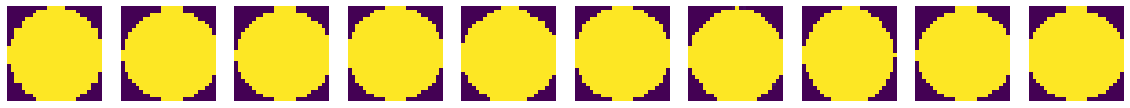

normal images


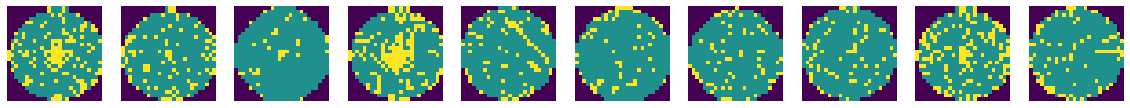

generated images


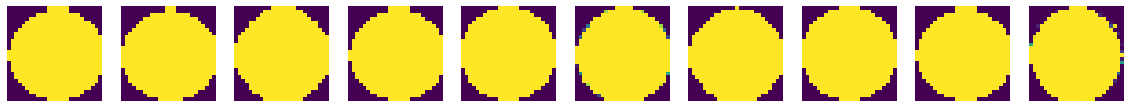

normal images


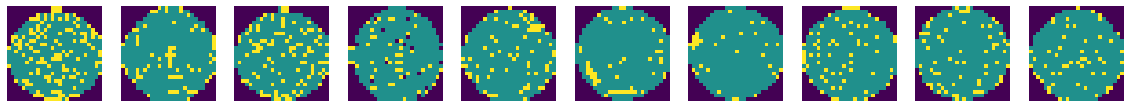

generated images


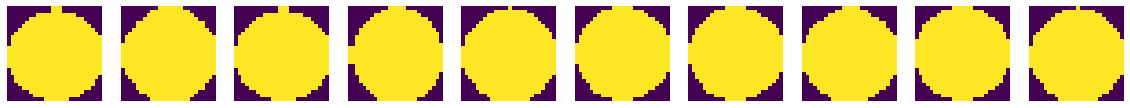

normal images


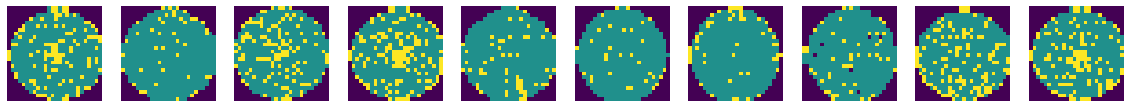

generated images


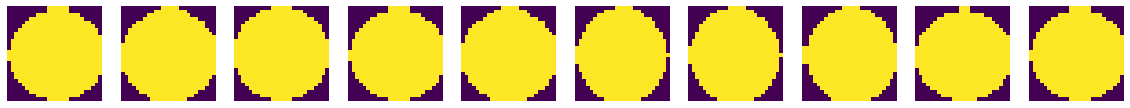

normal images


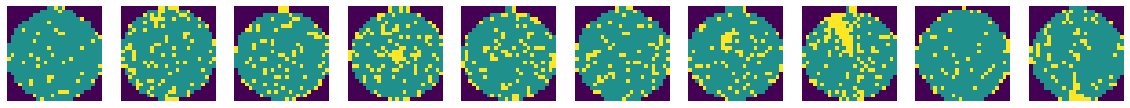

generated images


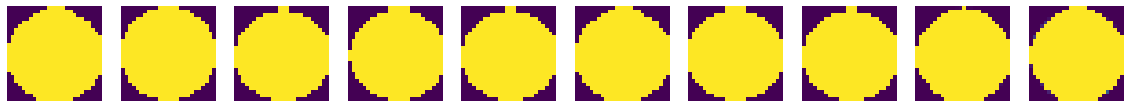

normal images


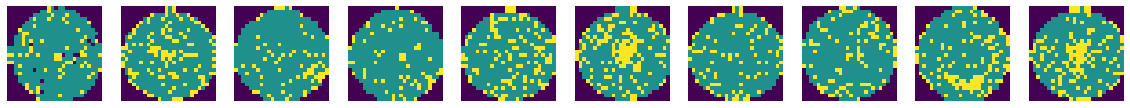

generated images


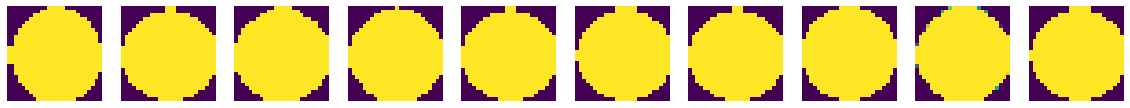

normal images


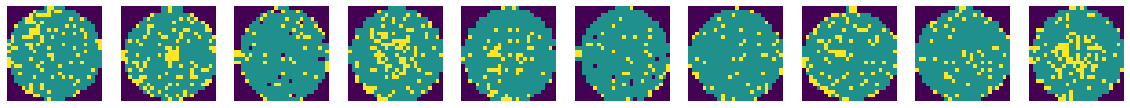

generated images


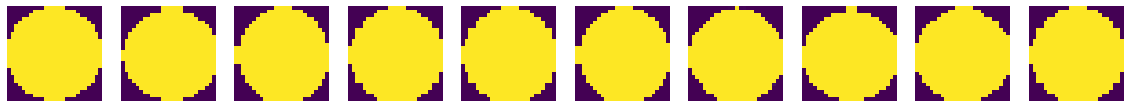

normal images


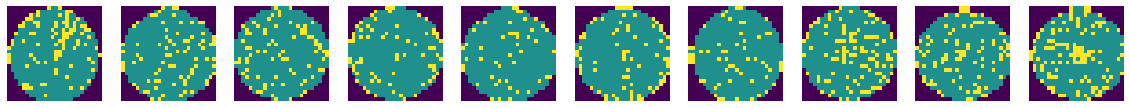

generated images


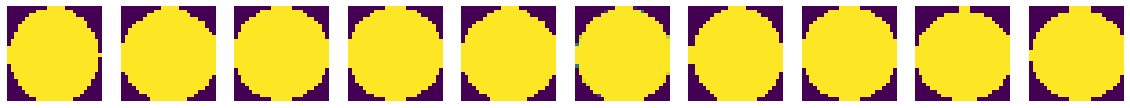

normal images


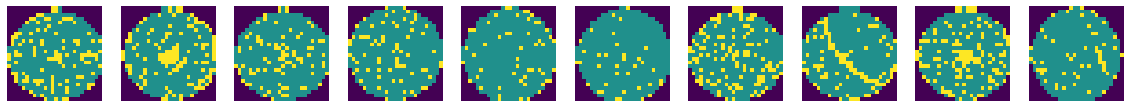

generated images


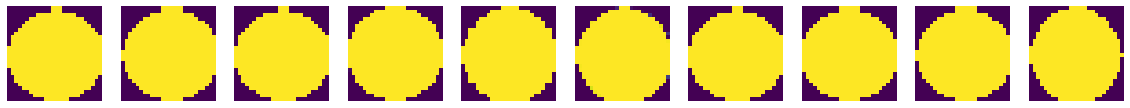

normal images


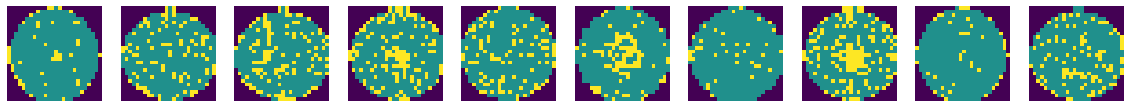

generated images


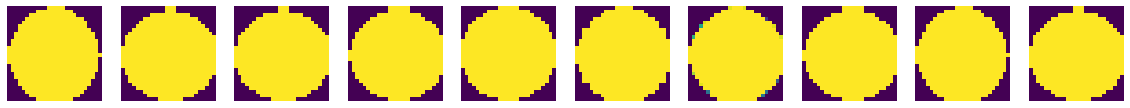

normal images


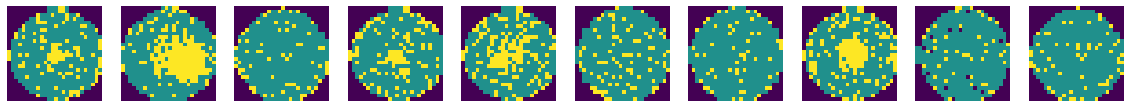

generated images


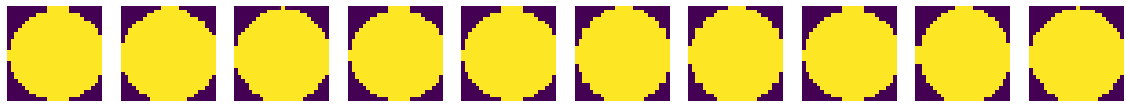

normal images


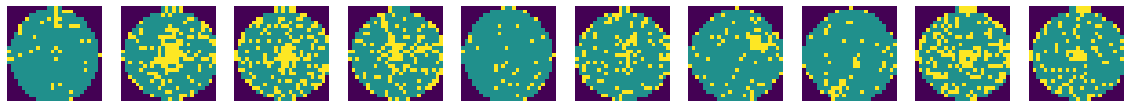

generated images


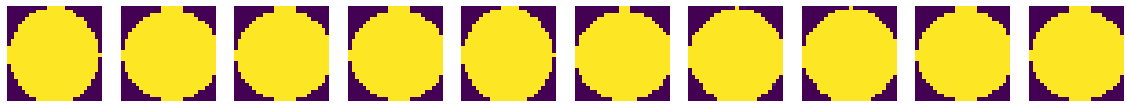

normal images


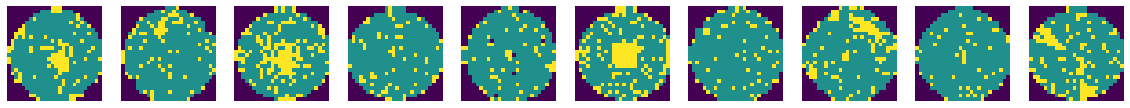

generated images


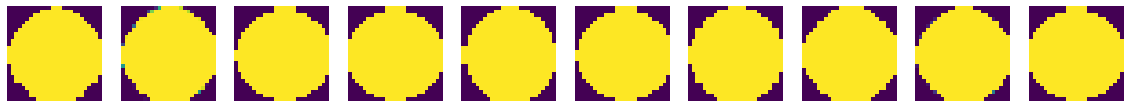

normal images


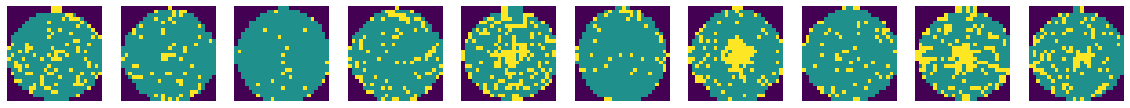

generated images


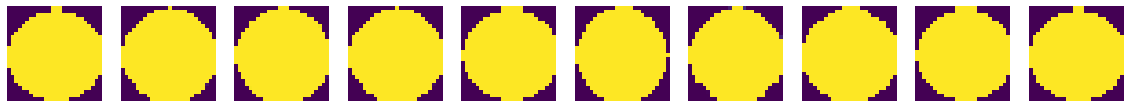

normal images


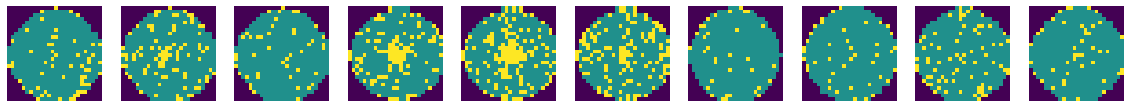

generated images


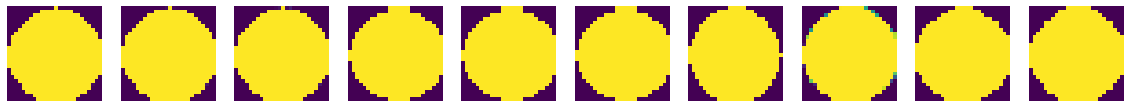

normal images


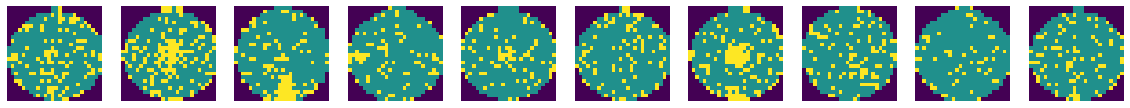

generated images


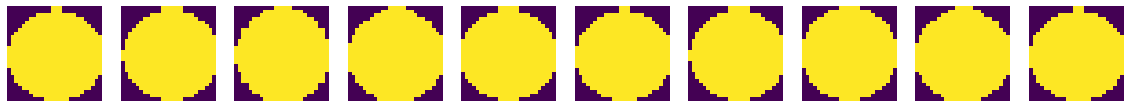

normal images


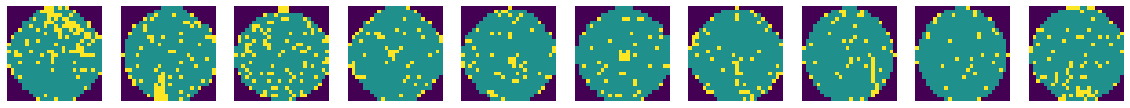

generated images


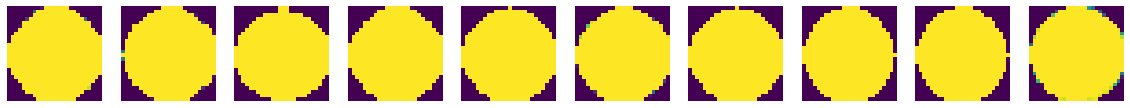

normal images


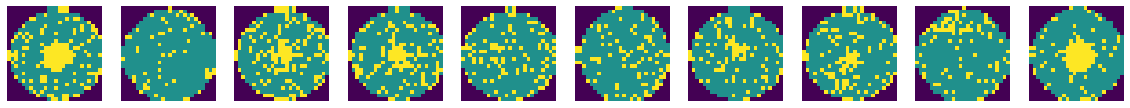

generated images


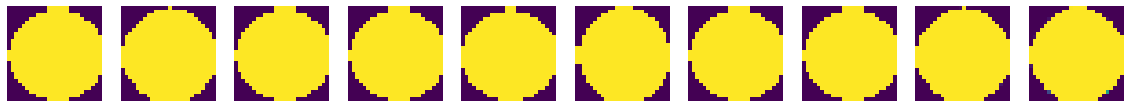

normal images


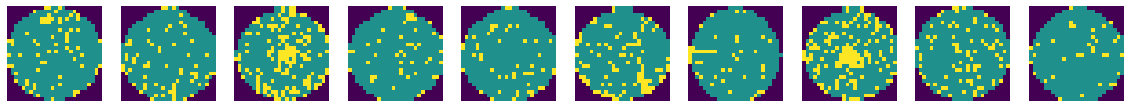

generated images


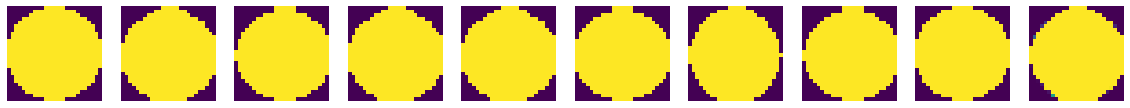

normal images


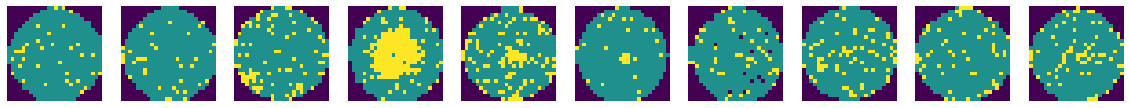

generated images


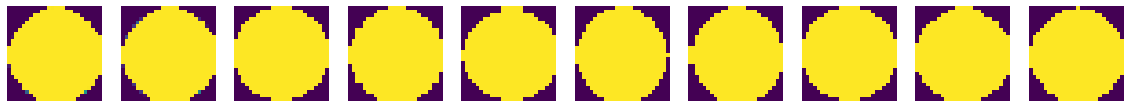

normal images


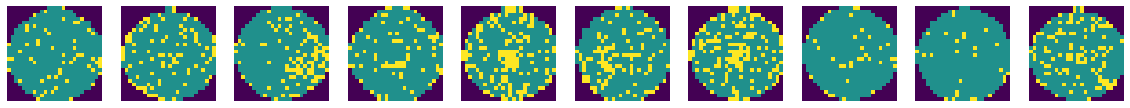

generated images


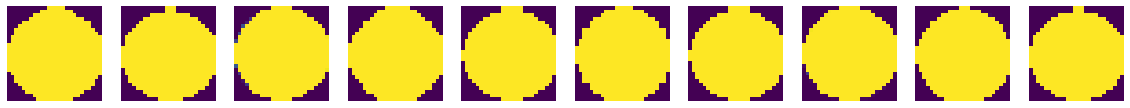

normal images


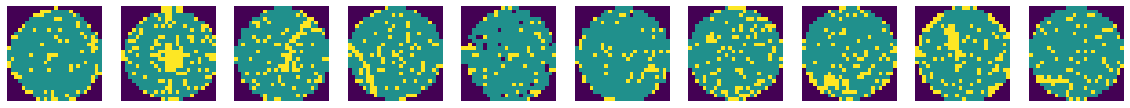

generated images


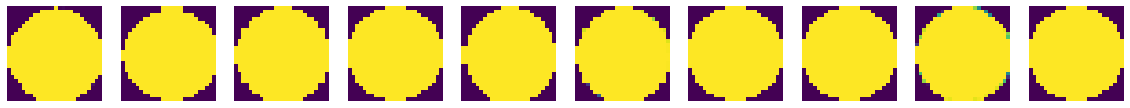

normal images


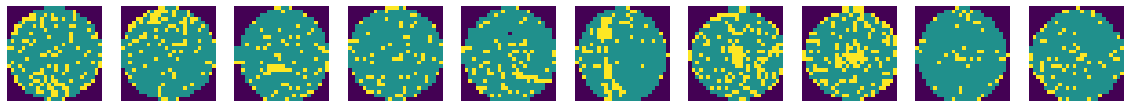

generated images


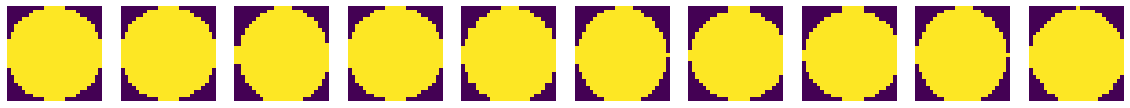

normal images


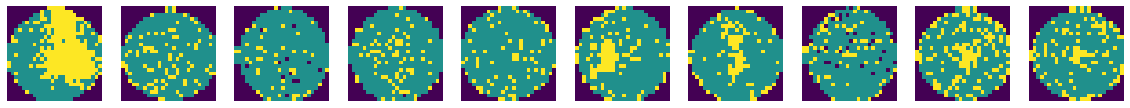

generated images


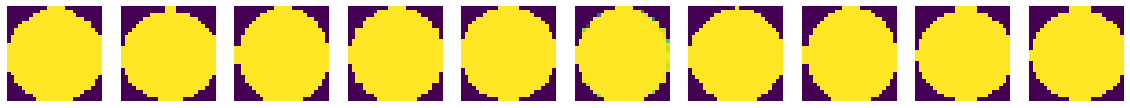

normal images


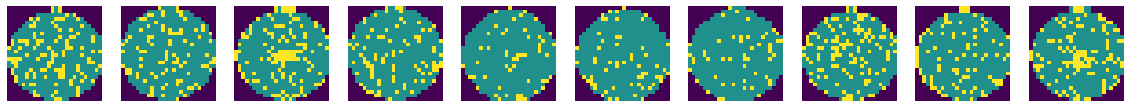

generated images


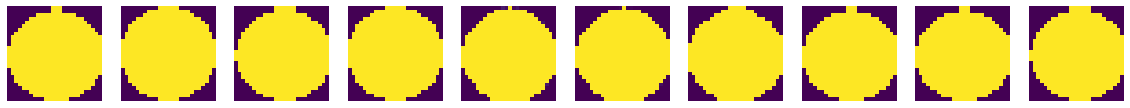

normal images


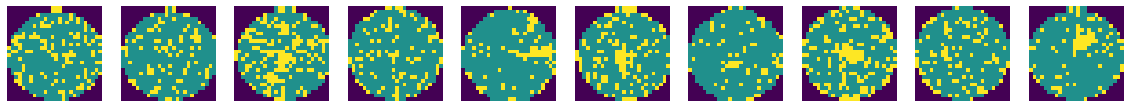

generated images


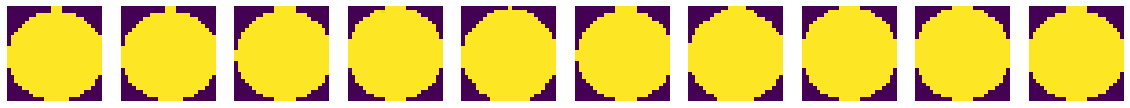

normal images


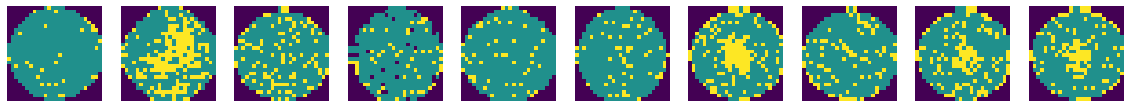

generated images


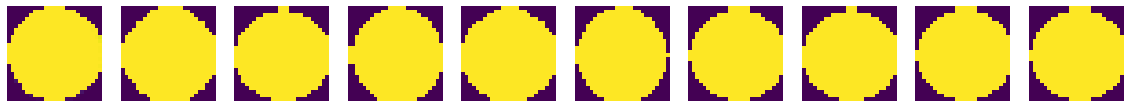

normal images


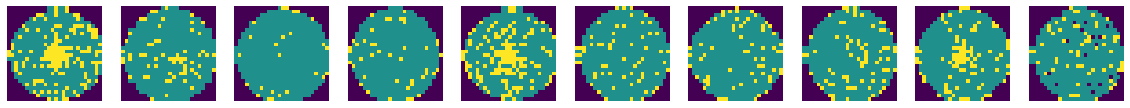

generated images


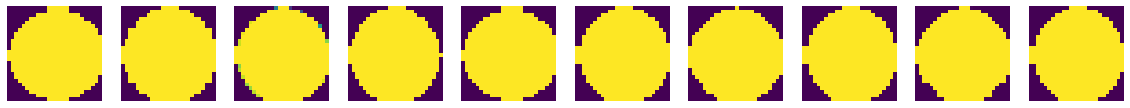

normal images


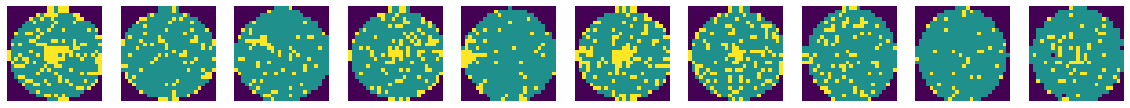

generated images


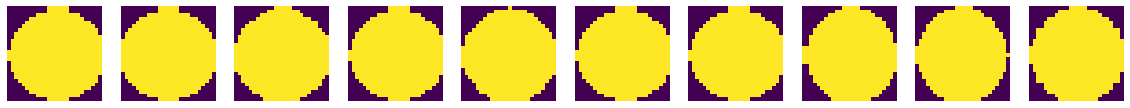

normal images


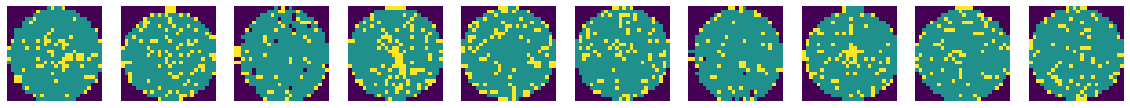

generated images


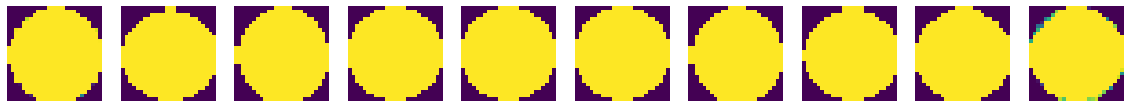

normal images


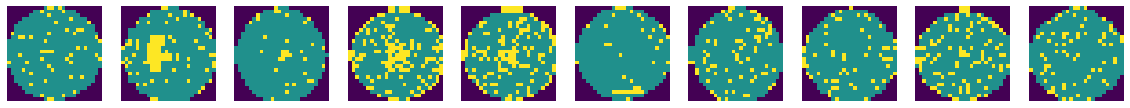

generated images


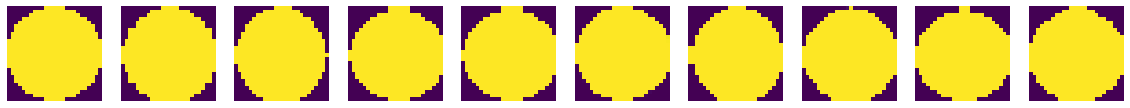

normal images


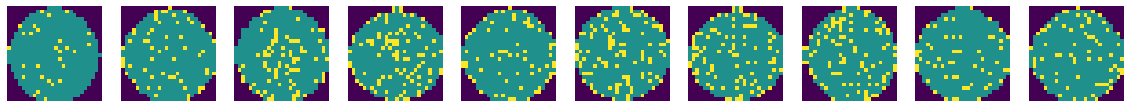

generated images


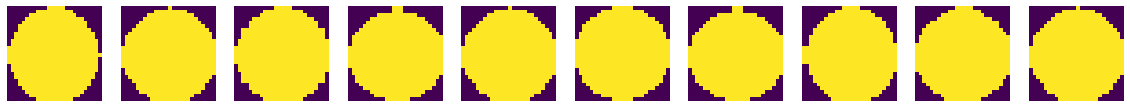

normal images


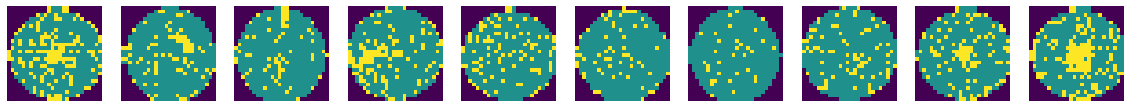

generated images


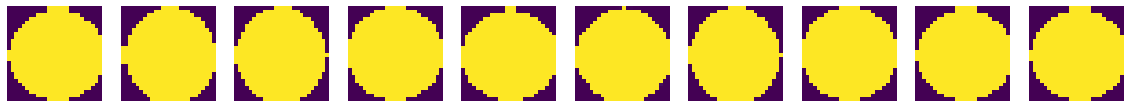

normal images


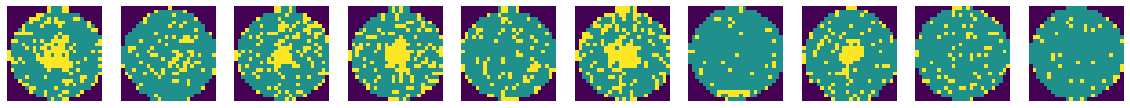

generated images


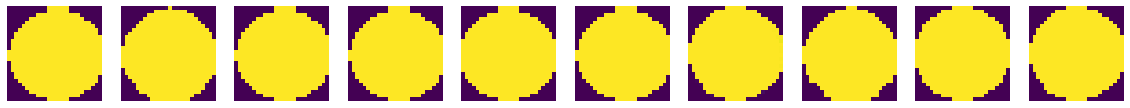

normal images


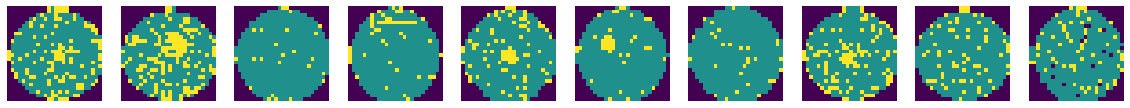

generated images


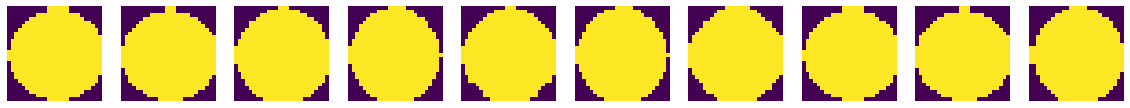

normal images


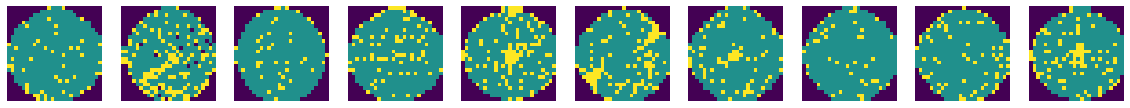

generated images


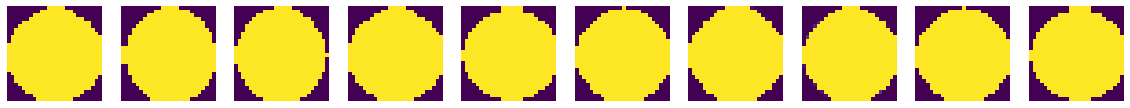

normal images


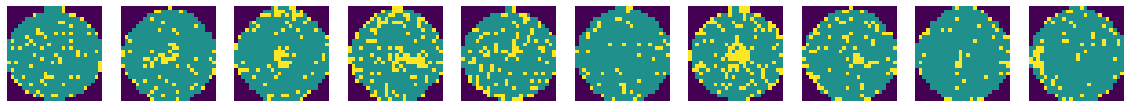

generated images


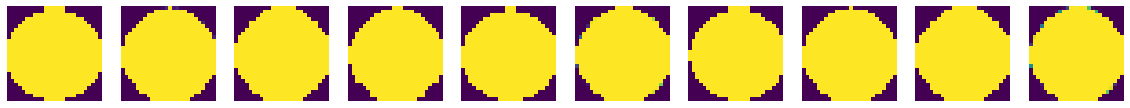

normal images


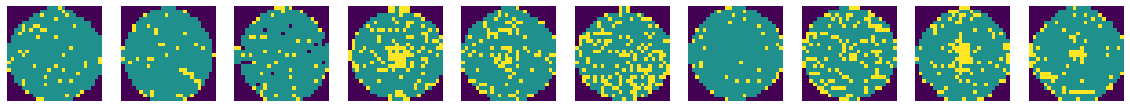

generated images


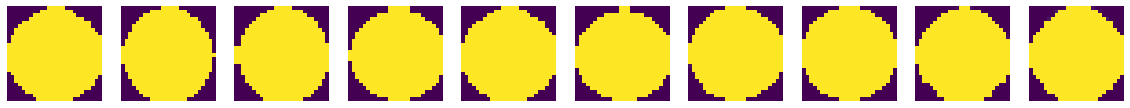

normal images


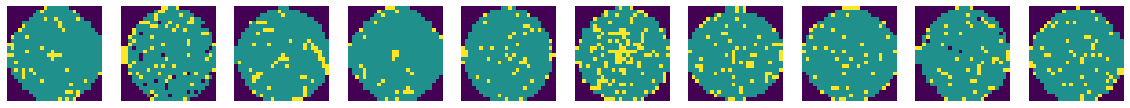

generated images


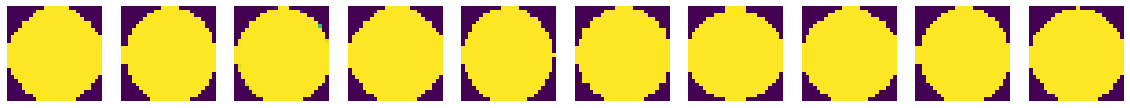

normal images


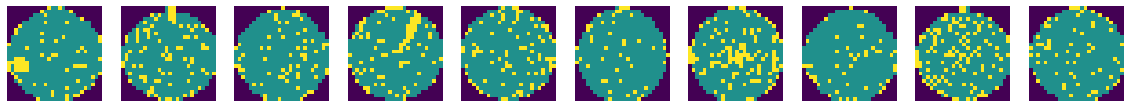

generated images


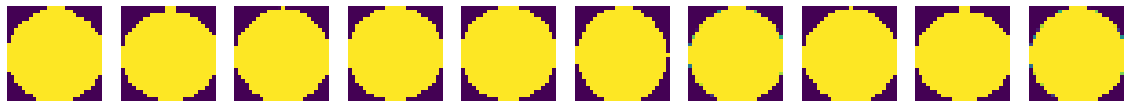

normal images


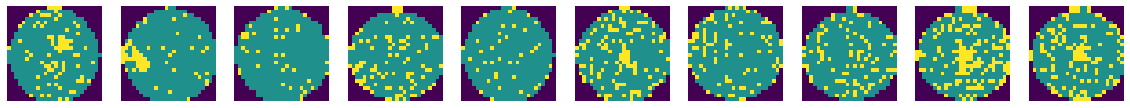

generated images


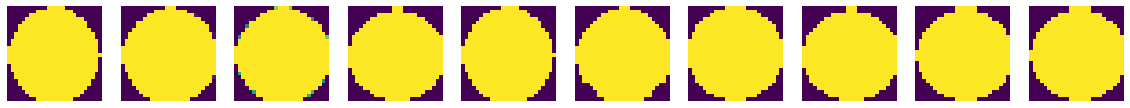

normal images


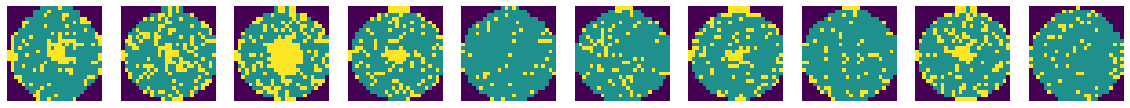

generated images


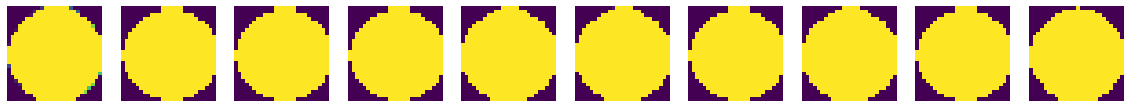

normal images


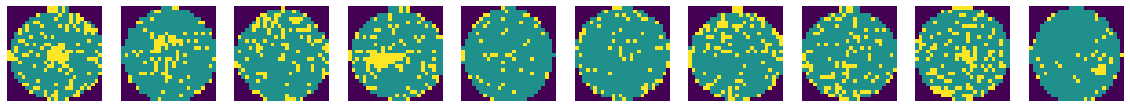

generated images


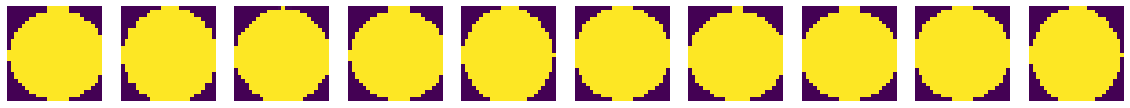

normal images


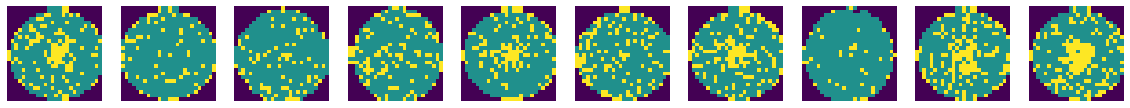

generated images


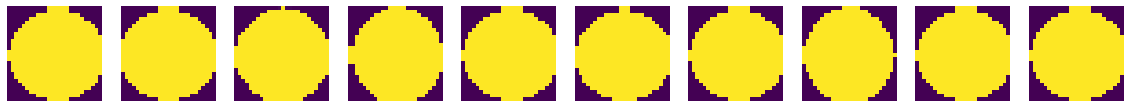

normal images


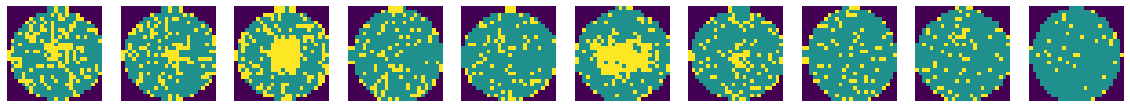

generated images


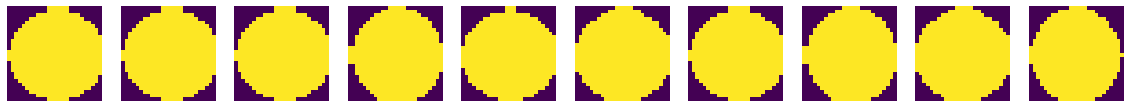

normal images


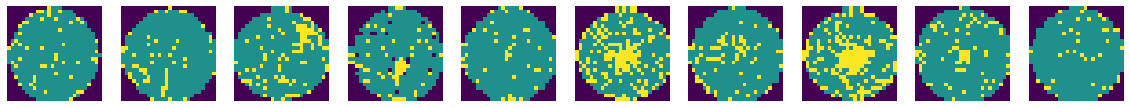

generated images


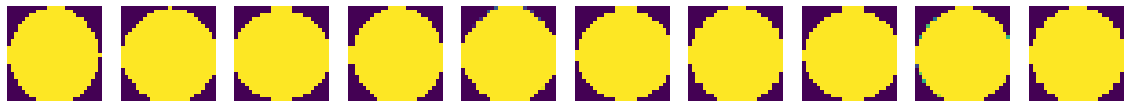

normal images


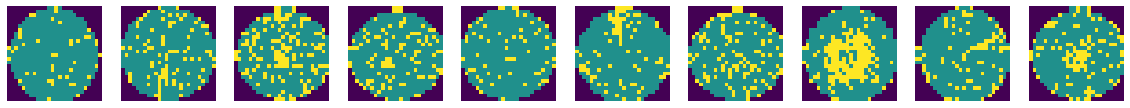

generated images


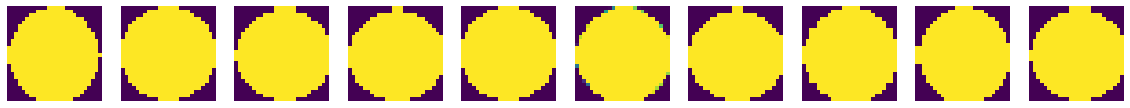

normal images


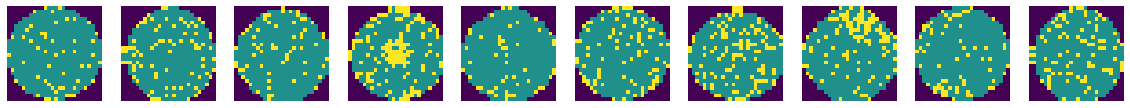

generated images


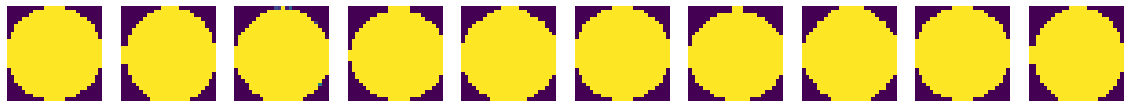

normal images


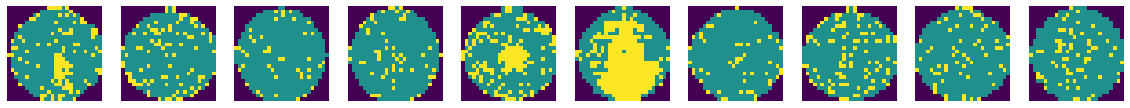

generated images


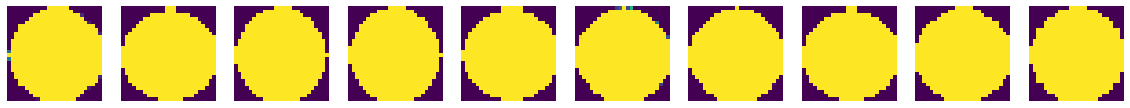

normal images


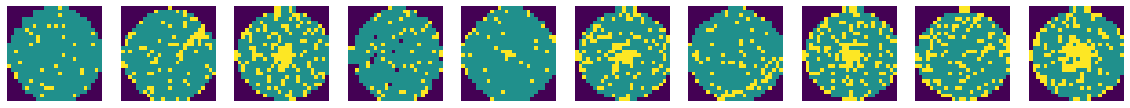

generated images


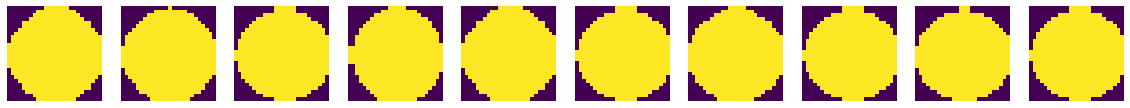

normal images


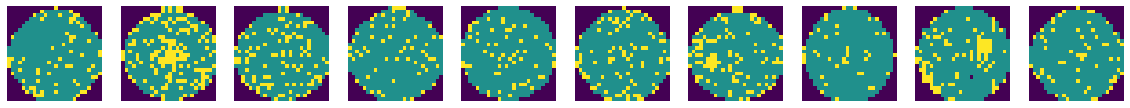

generated images


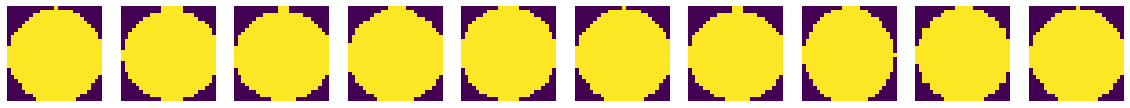

normal images


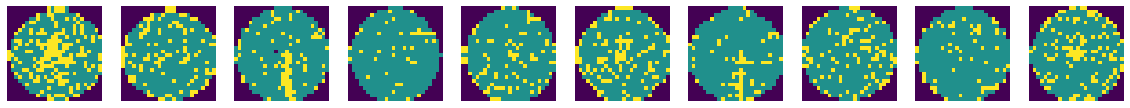

generated images


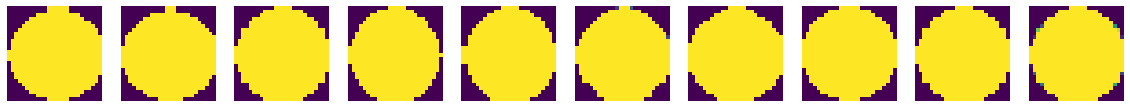

normal images


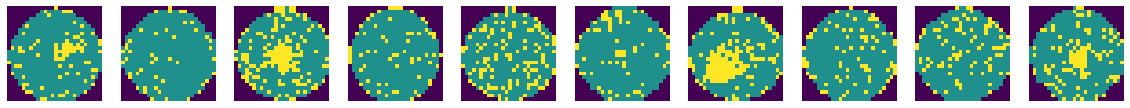

generated images


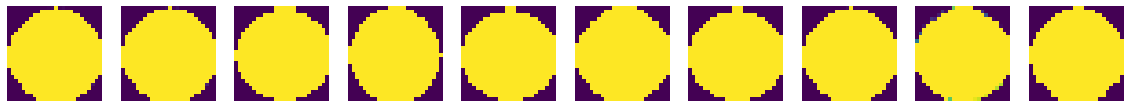

normal images


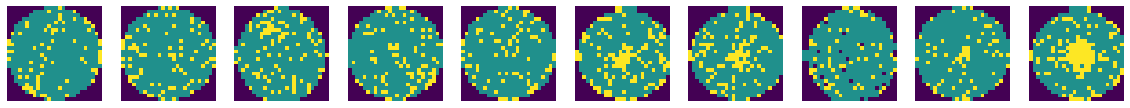

generated images


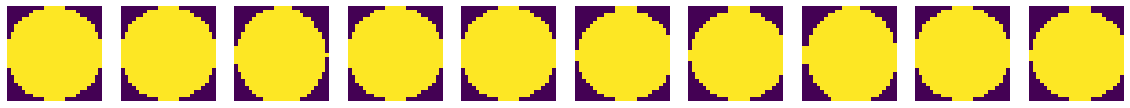

normal images


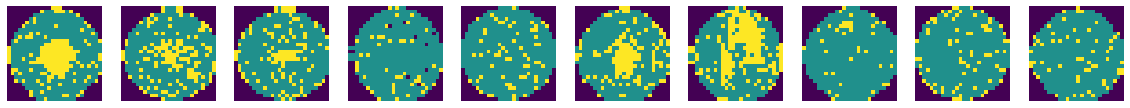

generated images


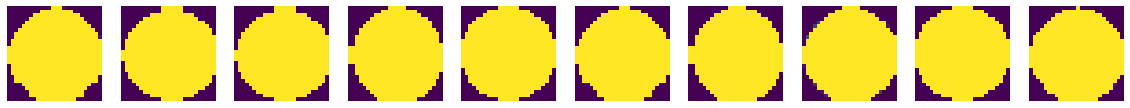

normal images


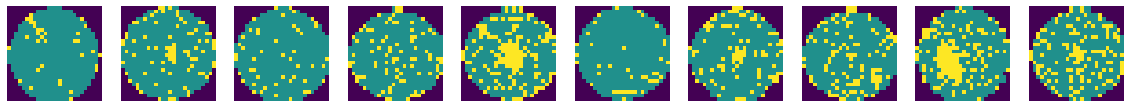

generated images


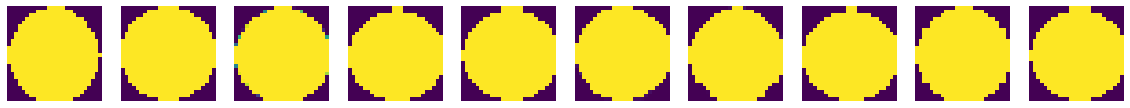

normal images


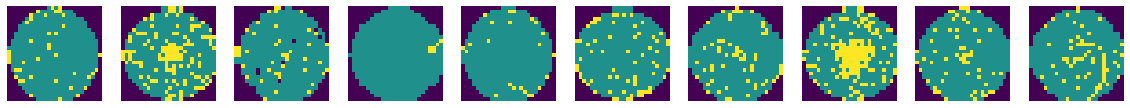

generated images


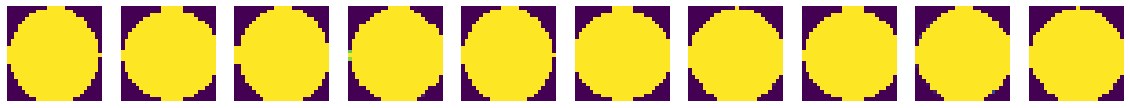

normal images


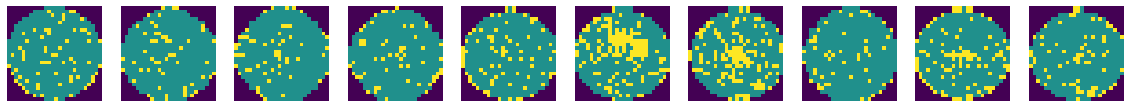

generated images


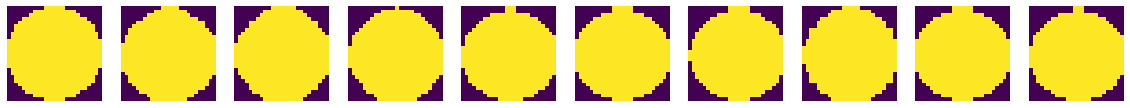

normal images


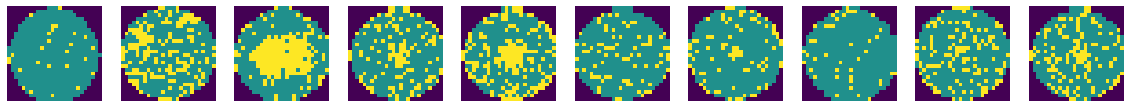

generated images


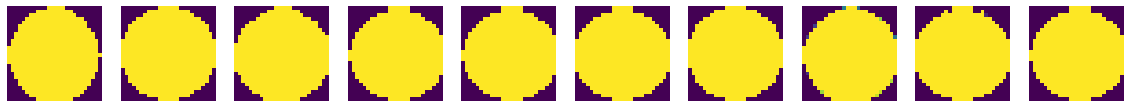

normal images


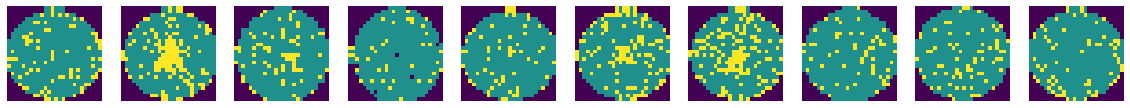

generated images


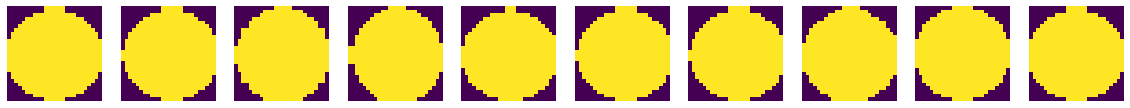

normal images


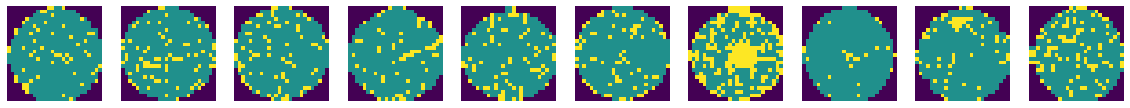

generated images


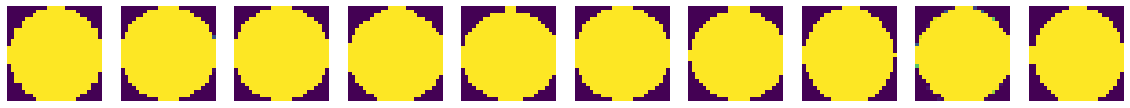

normal images


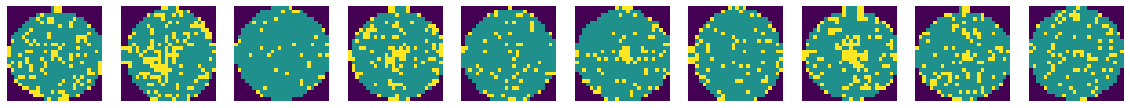

generated images


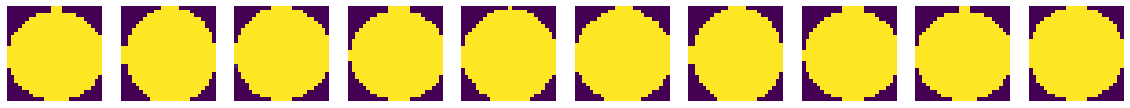

normal images


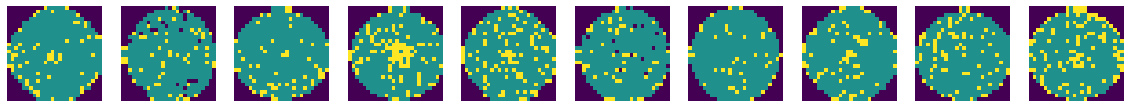

generated images


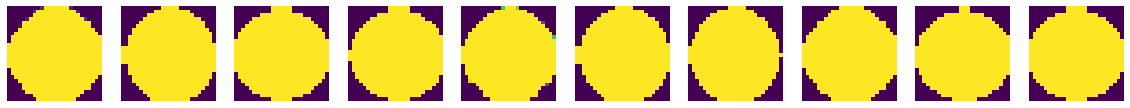

normal images


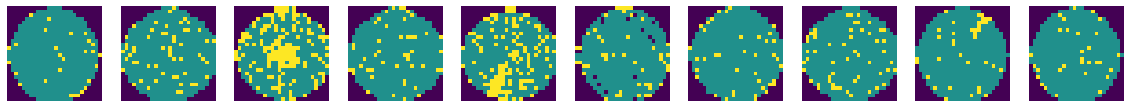

generated images


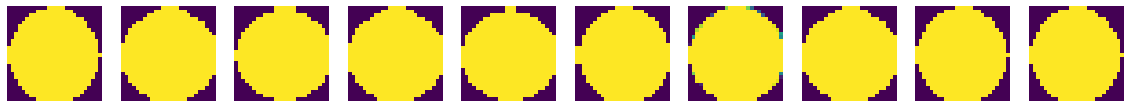

normal images


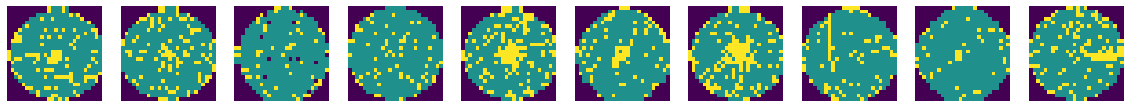

generated images


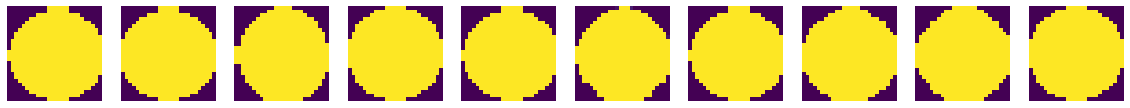

normal images


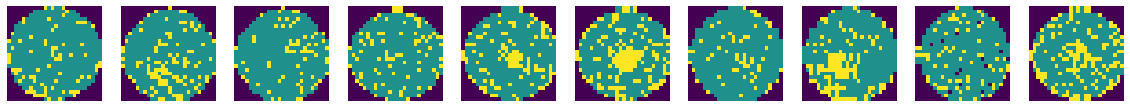

generated images


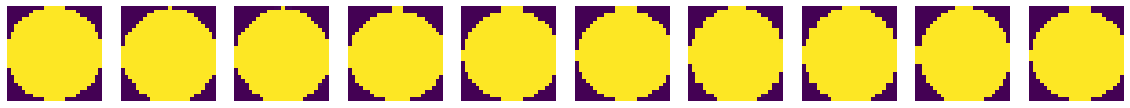

normal images


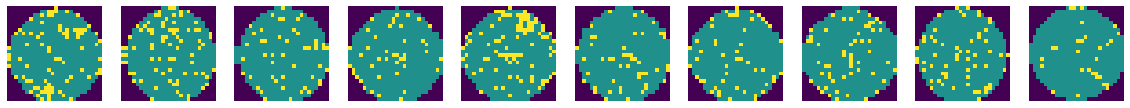

generated images


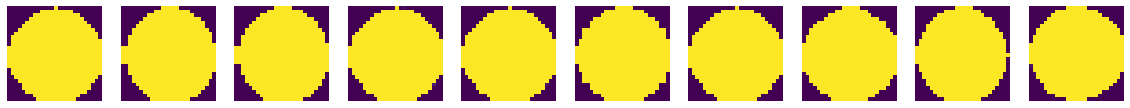

normal images


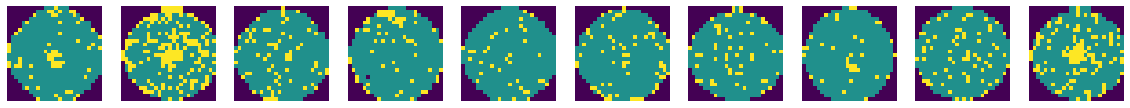

generated images


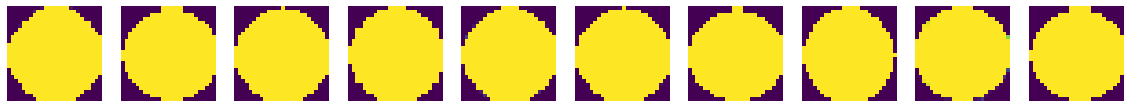

normal images


KeyboardInterrupt: 

<Figure size 1440x144 with 0 Axes>

In [187]:
#We can plot the generated images from our VAE Generative model
def show_images(x, ncols=10):
    x = x.view(-1, 26, 26)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].detach().numpy())
        ax[idx].axis('off')
    plt.show()

vae.eval()
with torch.no_grad():
    for idx, data in enumerate(train_dataloader):
        x, y = data
        if x.size()[0] ==10:
            x = x.view(batch_size, x_dim)
            x = x.to(DEVICE)
            x_reconstr, mu, log_sigma, z = vae(x)
            print('normal images')
            show_images(x.cpu())
            print('generated images')
            show_images(x_reconstr.cpu())

From the plot we can see that the reconstruction and elbo loss for a lot of samples in the production data is
huge. There is definitely a covariate shift in the dataset. We now need to identify these points by setting a 
threshold for the losses and then validate their poor performance on the trained MLP Clf.

## Part 2: address the data mining objective

Address the *common* data mining objective and document your findings in the report. You are free to use any approach you like. To get started you may read the required reading in the slides on Dataset Shift and follow the cited papers.

<br/>
<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
For this assignment only your report will be graded. While your code will not be graded directly, any results and figures in your report must be generated by your code below.
</div>

In [ ]:
#// BEGIN_TODO [CODE] (0 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [CODE]

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on this assignment?

Assign a number to variable `feedback_time`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_1] (0 points)

#// END_FEEDBACK [Feedback_1]

import numbers
assert isinstance(feedback_time, numbers.Number), "Please assign a number to variable feedback_time"

### How difficult did you find this assignment?

Assign an integer to variable `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_2] (0 points)

#// END_FEEDBACK [Feedback_2]

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to variable feedback_difficulty"

### (Optional) What did you like?

Assign a string to variable `feedback_like`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_5] (0 points)

#// END_FEEDBACK [Feedback_5]

### (Optional) What can be improved?

Assign a string to variable `feedback_improve`. Please be specific, so that we can act on your feedback.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_6] (0 points)

#// END_FEEDBACK [Feedback_6]